# 전체 계획
1. 데이터 로드 & 분리
    * train / test 데이터 분리
2. 탐색적 데이터 분석(EDA)
		* y값 비율 확인해보기 -> 후에 적은 비율의 케이스 학습 덜됨 가능성 확인
		* 결측치 확인
		* 기술 통계 및 시각화를 통한 EDA로 분포확인 & 이상치 확인
3. 데이터 전처리
    * 이상치 제거
        - 범주형은 딱히 이상치라고 판단할 일이 없을 테니 수치형에 대해서만 생각해보면
        - 그리고 만약 이상치 제거했으면 꼭 index 리셋해주기
    * 결측치 처리 (참고로 train 데이터 기준으로는 데이터 총 67405, 전체 데이터로는 96294)
        - 수치형: 근로시간(5671 = 3971+1700)
        - 범주형: 
        - 삭제 : -  
        처리하기 애매하다는 느낌 일단 내버려두고 차차 더 생각
		* 값 형식 통일
				- 근로기간 경우 같은 의미로 추정되나 양식을 다르게한 경우 존재하여 처리
		* 범주형 데이터 형식 변환(object -> category)
		* 데이터 비율 맞춰주기 위해 Oversampleing
        - 단, SMOTE 알고리즘은 수치형 데이터에만 쓸 수 있으니
        - SMOTE를 범주형 데이터에도 쓸 수 있게 확장한 SMOTENC를 사용
		* 컬럼 분리 (수치형 데이터에 범주형의 의미도 같이 내포되어 있는 경우)
				- 최근_2년간_연체_횟수, 총상환이자?, 총연체금액, 연체계좌수
    * 스케일링
		- 수동 로그스케일링:
			- <strike>총연체금액: 로그스케일링해주기</strike> -> 불필요할듯하여 취소
	    - 수치형 데이터: '대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수'
		    - 표준화(sd_sc): '연간소득'?, '부채_대비_소득_비율'? ->조금 애매함 튜터님과 상의
			- 정규화(mm_sc): '대출금액', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수'
	* 인코딩
		- y 변수 인코딩: 
        - 순서가 중요한 순서형 데이터: (map이나 다른 패키지의 모듈 사용)
        - 레이블 인코딩: 대출기간, 근로기간 (순서나 관계가 있는 경우에는 이 두 가지 외의 다른 인코딩을 해주어야할 수도 있는듯 함)
        - 원-핫 인코딩 : 주택소유상태, 대출목적
            - get_dummy:
            - 원-핫 인코딩:
    
4. 모델 수립
5. 평가

# 데이터 불러오기, 자료형 확인 및 처리

In [1]:
#기본 모듈 불러오기 
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import joblib
import sys
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, multilabel_confusion_matrix, make_scorer
from scipy import stats
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 아래에서 따로 이용하는 모듈
from matplotlib.ticker import MultipleLocator
import math
from imblearn.over_sampling import SMOTENC

# # warning을 모두 무시하는 것은 좋지 않으나 과제 수행을 쉽게할 수 있도록 무시설정
# import warnings
# warnings.filterwarnings(action='ignore')

# 그래프 한글 깨지는 것 방지
plt.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['font.size'] = 15
plt.rcParams['axes.unicode_minus'] =False

처음에는 ID에 대해서는 따로 쓰이지 않을 것이니 인덱스로 사용하자 했는데 그로 인해서 경고가 너무 많이 발생하는 듯하여    
다시 원래의 기본 인덱스를 사용하여야 할 듯하며, ID는 학습할 때 굳이 필요없으니 train과 test데이터 df에서 제외시켜주도록하였다   
나중에 정렬을 한다던가하여 필요한 일이 생긴다면 다시 가져와야 할 수도 있다

In [2]:
train_df = pd.read_csv('./train.csv') # 첫번째 열인 ID를 index로 사용 ->부분 다시 제외
real_test = pd.read_csv('./test.csv') # 첫번째 열인 ID를 index로 사용 ->부분 다시 제외
submission = pd.read_csv('sample_submission.csv')
cols = train_df.columns.to_list()
display(cols)
numeric_col = train_df._get_numeric_data().columns.to_list() # ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수']
target = '대출등급'
display(train_df.columns.difference(numeric_col))
category_col = [col for col in train_df.columns if col not in numeric_col]
#category_col = train_df.columns.difference(numeric_col).tolist()#category_col = list(set(cols)-set(numeric_col)) # ['대출기간', '근로기간', '주택소유상태', '대출목적']
# train_df.iloc[[42717,82476,21126]] 기존 탑 3개 인덱스들
category_col.remove(target)
display(numeric_col, category_col)

['ID',
 '대출금액',
 '대출기간',
 '근로기간',
 '주택소유상태',
 '연간소득',
 '부채_대비_소득_비율',
 '총계좌수',
 '대출목적',
 '최근_2년간_연체_횟수',
 '총상환원금',
 '총상환이자',
 '총연체금액',
 '연체계좌수',
 '대출등급']

Index(['ID', '근로기간', '대출기간', '대출등급', '대출목적', '주택소유상태'], dtype='object')

['대출금액',
 '연간소득',
 '부채_대비_소득_비율',
 '총계좌수',
 '최근_2년간_연체_횟수',
 '총상환원금',
 '총상환이자',
 '총연체금액',
 '연체계좌수']

['ID', '대출기간', '근로기간', '주택소유상태', '대출목적']

ID 칼럼은 유일성이 확인되고, 의미상으로도 key의 역할인듯.  
데이터로서 사용하기에는 무리가 있을듯 하며, 인덱스로 활용하거나 제거.

In [3]:
# ID 칼럼 제거
train= train_df.drop('ID', axis = 1) # train_df: 불러온 상태 그대로, train : ID열 제거해준 상태
real_test = real_test.drop('ID', axis = 1)
category_col.remove('ID')

In [4]:
train['근로기간'].replace({'3':'3 years', '<1 year':'< 1 year', '1 years':'1 year', '10+years':'10+ years'}, inplace=True)
real_test['근로기간'].replace({'3':'3 years', '<1 year':'< 1 year', '1 years':'1 year', '10+years':'10+ years'}, inplace=True)

In [5]:
order_grade = ['A','B','C','D','E','F','G']

# EDA

## y값 비율 확인해보기
- 비율 상으로 비슷하게 존재하지 않아서 낮은 E?,F,G 정도 oversampleing해야할 수도 있는데 일단 그냥 안하고 해봄

## 시각화를 통한 EDA

### 수치형 데이터 시각화

#### 시각화 전 데이터 다시 한번 확인

In [6]:
numeric_col

['대출금액',
 '연간소득',
 '부채_대비_소득_비율',
 '총계좌수',
 '최근_2년간_연체_횟수',
 '총상환원금',
 '총상환이자',
 '총연체금액',
 '연체계좌수']

In [7]:
for check_col in numeric_col+category_col: # numeric_col의 경우는 그냥 리스트가 아니라 index의 리스트형태?로 되어있어서 list붙여줌
    # print(check_col, " : ", len(set(X_train[check_col]))) # 중복없이 값종류 갯수
    print(check_col, " : ", len(train[check_col].unique())) # 중복없이 값종류 갯수

대출금액  :  1340
연간소득  :  7726
부채_대비_소득_비율  :  4025
총계좌수  :  109
최근_2년간_연체_횟수  :  20
총상환원금  :  27797
총상환이자  :  35626
총연체금액  :  109
연체계좌수  :  4
대출기간  :  2
근로기간  :  12
주택소유상태  :  4
대출목적  :  12


#### 시각화 부분

C:\Users\kssg1\AppData\Local\Temp\ipykernel_31360\3541434265.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  num_bin = entire_range / bin_width


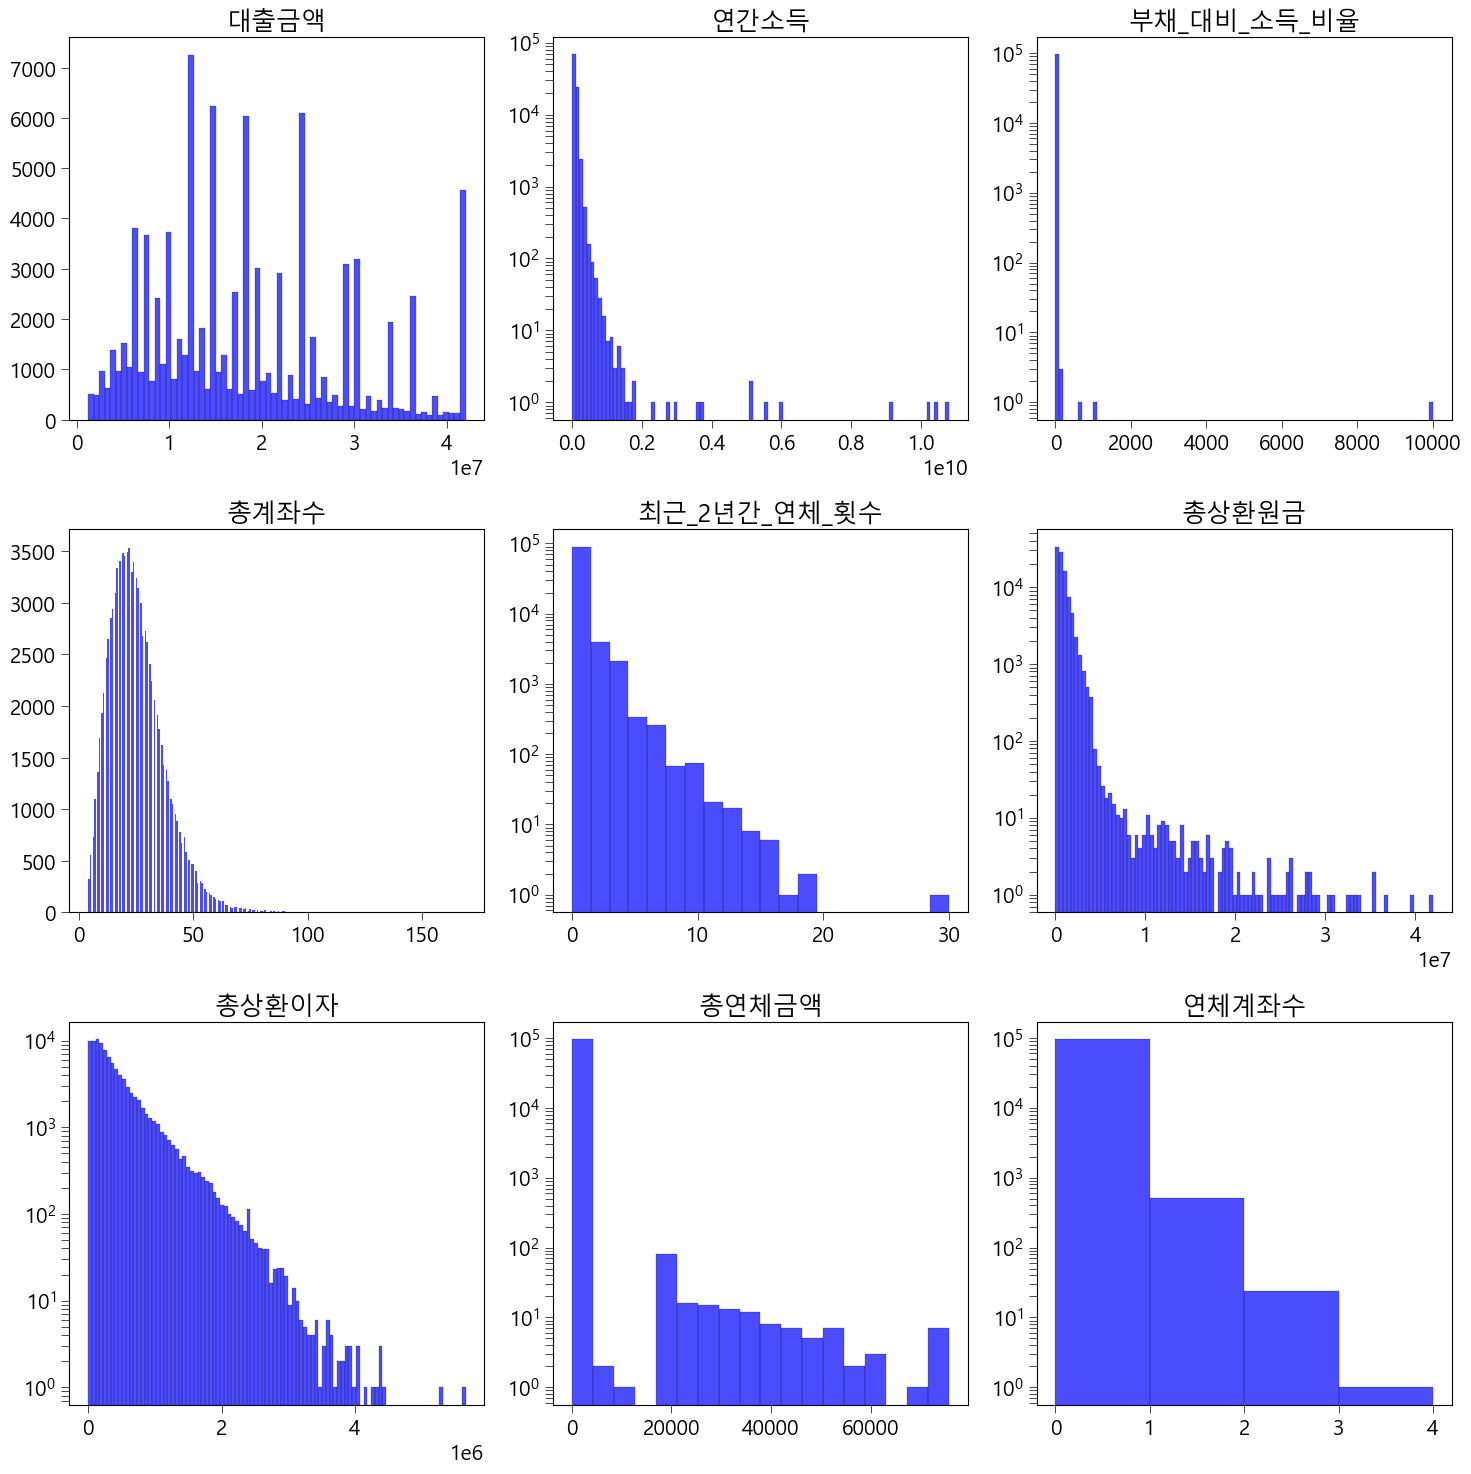

In [8]:
#수치형 변수 시각화
def get_3_hist_num(data:pd.DataFrame, columns:list, whether_log_scale: bool = True, 
                                        log_scale_threshold: float = 5000, bin_control: bool =True, num_bin_max: int = 300, num_bin_set: int = 80):
    """ 데이터와 컬럼을 전달하면 히스토그램을 3개씩 출력해주는 함수

    Args:
        data (pd.DataFrame): 데이터프레임
        columns (list): 컬럼 리스트
        bar_width_ratio(float): 원하는 비율로 설정 (예시로 0.005 사용)
    """
    num_plots = len(columns)
    num_rows = (num_plots + 2) // 3  # 서브플롯의 행 수 계산
    num_cols = min(num_plots, 3)  # 서브플롯의 열 수 계산
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    
    for i, col in enumerate(columns):
        row_idx, col_idx = divmod(i, 3)
        axes[row_idx, col_idx].clear()
        n_bins = 'auto'
        
        if bin_control == True :
            # Freedman-Diaconis' Choice방식으로 bin 갯수 얼추 계산해본 뒤 판단
            entire_range = train[col].max() - train[col].min() # 데이터 값 최대와 최소 차이
            q1 = np.percentile(train[col], 25)
            q3 = np.percentile(train[col], 75)
            IQR = q3 - q1
            N = train[col].count()
            bin_width = 2 * (IQR / N**(1/3))
            num_bin = entire_range / bin_width
            # print(col, "의 bin : ", num_bin) # 점검용
            if len(set(data[col])) <= 20:
                n_bins = len(set(data[col]))
            elif (not math.isinf(num_bin)) and num_bin > num_bin_max:
                n_bins = num_bin_set
            else:
                n_bins = 'auto' # 지워도 괜찮을듯
        
        # # Wand 규칙을 사용하여 동적으로 bin의 개수 설정
        # if bar_width_ratio < bar_width_ratio_min:  # 전체 스케일에 대한 막대 두께의 비율이 너무 작으면
        #     n_bins = int(np.sqrt(len(set(data[col])))*1.0) 
        #     # 조금더 줄이면 깔끔히 잘보이지 않을까해서 0.8곱했다가 별차이없는듯해서 1.0으로 원 위치(원래 곱해진 것 따로 없었음)
        # else:
        #     n_bins = 'auto'
            
        hist, bins, _ = axes[row_idx, col_idx].hist(data[col], bins=n_bins, color='blue', edgecolor='blue', linewidth=0.2, alpha=0.7)
        num_bin_actual = len(bins) - 1  # 실제로 그려진 막대의 갯수
        #sns.histplot(data[col], ax=axes[row_idx, col_idx], bins=n_bins, color='blue', edgecolor='blue', linewidth=0.2, alpha=0.7, kde=False)
        
        axes[row_idx, col_idx].set_title(col)
        axes[row_idx, col_idx].tick_params(axis='both', which='both', direction='out', length=6, width=0.5)  # 눈금 표시
        
        bar_heights = [rect.get_height() for rect in axes[row_idx, col_idx].patches]
        max_height = max(bar_heights)
        min_height = max(min(bar_heights),1)
        
        # print(col, " 높이차는 이러함 : ", max_height / min_height, max_height, min_height) # 점검용
        # print(col, " bin : ", num_bin_actual) # 점검용
        
        # 히스토그램 바의 높이 차이에 따라 리니어 스케일 또는 로그 스케일 선택
        if whether_log_scale == True and (max_height / min_height) > log_scale_threshold:
            axes[row_idx, col_idx].set_yscale('log')  # 로그 스케일로 변환
        else:
            axes[row_idx, col_idx].set_yscale('linear')  # 리니어 스케일로 유지
        
        # 전체 그래프 스케일에 대한 막대 자체의 두께 비율 계산
        total_width = axes[row_idx, col_idx].get_xlim()[1] - axes[row_idx, col_idx].get_xlim()[0]
        
        
        
        # 히스토그램 바의 두께가 조건에 따라 테두리 색 설정
        for rect in axes[row_idx, col_idx].patches:
            bar_width = rect.get_width()
            if bar_width / total_width > 0.005: # 그냥 저쯤보다 얇은 경우 테두리 없는게 나은듯해서 설정해줌
                rect.set_edgecolor('black')
            else:
                rect.set_edgecolor('none')  # 얇은 경우에는 테두리 없애기
        
        # # Seaborn axis 객체로부터 눈금 위치 확인
        # tick_locs = sns.histplot(data[col]).axes.get_xticks()
        # print(f"{col}의 현재 x 축 눈금 위치: {tick_locs}")

    # 남은 서브플롯에 빈 그래프 그리기
    for i in range(num_plots, num_rows * num_cols):
        row_idx, col_idx = divmod(i, 3)
        axes[row_idx, col_idx].clear()  # 남은 서브플롯 비우기
        axes[row_idx, col_idx].axis('off')  # 빈 서브플롯 제거
        
    

    # 전체 그림 표시
    plt.tight_layout()
    plt.show()
get_3_hist_num(train, numeric_col, log_scale_threshold=8000, num_bin_max=270, num_bin_set=100)

#### 추가확인용

<Axes: xlabel='총상환이자', ylabel='Count'>

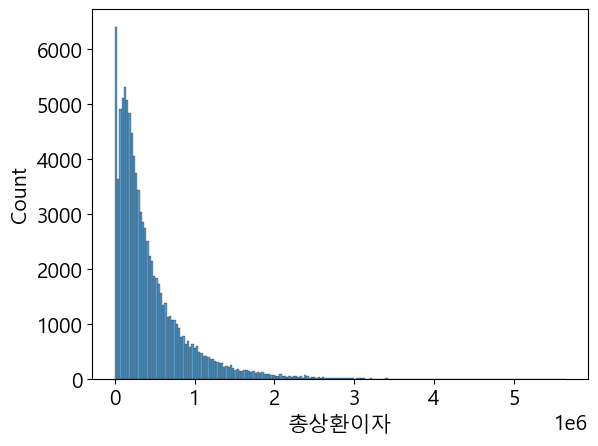

In [9]:
sns.histplot(train, x='총상환이자', bins=200)

In [10]:
train['총상환이자'].value_counts()

총상환이자
0.0          5444
156144.0       77
99312.0        73
85596.0        71
147276.0       70
             ... 
917364.0        1
774948.0        1
1131756.0       1
567804.0        1
818076.0        1
Name: count, Length: 35626, dtype: int64

In [11]:
train[train['부채_대비_소득_비율']>2000]['부채_대비_소득_비율'].value_counts() # -> 이상치로 판단

부채_대비_소득_비율
9999.0    1
Name: count, dtype: int64

In [12]:
print(train[train['최근_2년간_연체_횟수']==0]['최근_2년간_연체_횟수'].value_counts())
print(train[train['최근_2년간_연체_횟수']>0]['최근_2년간_연체_횟수'].value_counts())

최근_2년간_연체_횟수
0    76392
Name: count, dtype: int64
최근_2년간_연체_횟수
1     13079
2      3896
3      1430
4       697
5       338
6       178
7        86
8        67
9        40
10       35
11       21
12        9
14        8
13        8
16        4
18        2
15        2
17        1
30        1
Name: count, dtype: int64


In [13]:
train[train['총연체금액']<1]['총연체금액'].count()

96113

#### violin plot

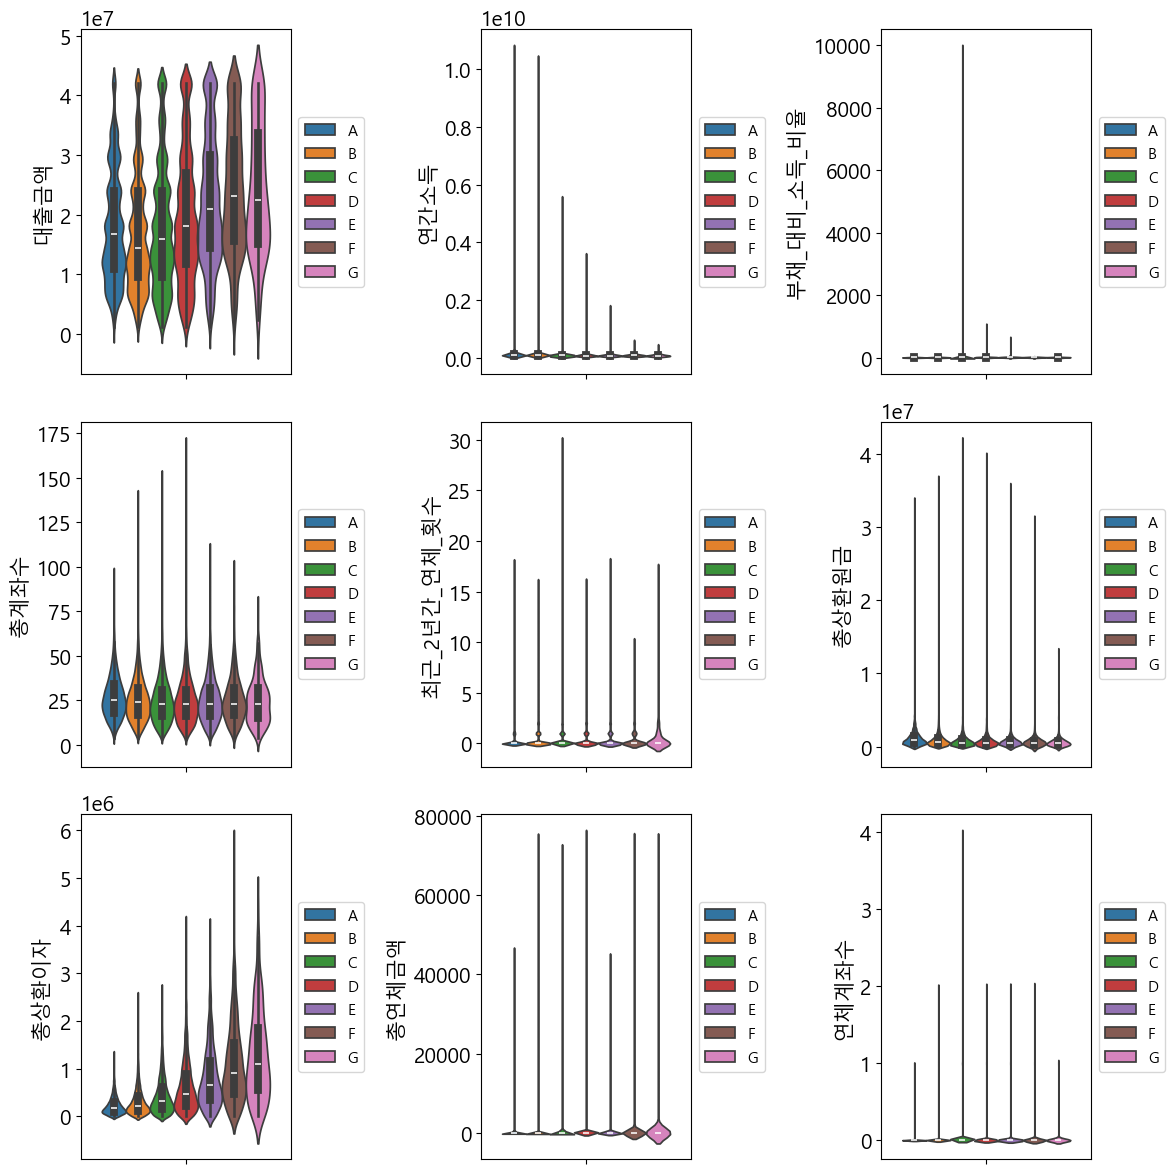

In [14]:
plt.figure(figsize=(12,12))
for idx, feature in enumerate(numeric_col):
    plt.subplot(3,3,idx+1)
    sns.violinplot(y=numeric_col[idx], hue = target, data = train_df, hue_order= order_grade)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=11)
plt.tight_layout()
plt.show()

#### 판단
- '연간소득': 로그스케일 고려할 필요 없을듯 최소랑 최대랑 그리 막 차이 나진 않아서
- '부채_대비_소득_비율': 9999.0으로 이상치 하나 있는 것으로 판단됨
- '최근_2년간_연체_횟수': <u>__0인 것과 아닌 것 구분해서 범주 컬럼으로 하나 추가해주기__</u>, log스케일은 할 필요 없을듯, 17이후 30이라 30을 이상치로 볼지는 염두만
- '총상환원금': 로그스케일 고려할 필요 없을듯 최소랑 최대랑 그리 막 차이 나진 않아서
- '총상환이자': <u>__0인 것과 아닌 것 구분해서 범주 컬럼으로 하나 추가해주기__</u>, 로그스케일 고려     
-> 간격 균일하긴 한데 커질수록 살짝 퍼지는 느낌, 0제외하고는 왼쪽 쏠린 정규분포 느낌
- '총연체금액': <u>__0인 것과 아닌 것 구분해서 범주 컬럼으로 하나 추가해주기__</u>, 로그스케일 고려     
-> 간격 균일하긴 한데 커질수록 살짝 퍼지는 느낌, 0제외하고는 왼쪽 쏠린 정규분포 느낌
- '연체계좌수': <u>__0인 것과 아닌 것 구분해서 범주 컬럼으로 하나 추가해주기__</u>


이상치가 존재하여 분포의 확인을 어렵게 함

# 데이터 전처리
- 이상치
	- 판단 기준: 	
		- z-score, IQR, ESD 등등
	- 부채_대비_소득_비율 9999.0로 이상치 하나 존재 제거
- 결측치
	- 근로기간 결측치 Unknown 처리 고민 , Unkown형태는 없었지만 더 확인해볼 필요는 있을듯
- <strike>값 형식 불일치
	- 근로기간 값 형식이 일치 안된 것이 많아서
		- 10+years를 10+ years 로 통일시켜주기
		- < 1 year를 <1 year로 통일시켜주거나, 아니면 0 year로 통일시켜주기
		- 1 years를 1 year로 통일시켜주기
		- 3을 3 years로 통일시켜주기 </strike>
- 데이터 형식 바꿔주기
	- 범주형 데이터 object에서 category로 형식 변경, 그리고 카테고리 순서정해줄 것은 순서 정해주기
- <strike>데이터 비율 맞춰주기 위해 Oversampleing
	- 단, SMOTE 알고리즘은 수치형 데이터에만 쓸 수 있으니
    - SMOTE를 범주형 데이터에도 쓸 수 있게 확장한 SMOTENC를 사용</strike>
- 컬럼 분리
	- 최근_2년간_연체_횟수, 총상환이자, 총연체금액, 연체계좌수 : 0인 것과 아닌 것 구분해서 범주컬럼으로 추가해주기

- 스케일링
	- 수동 로그스케일링:
		- <strike>총연체금액: 로그스케일링해주기</strike> -> 불필요할듯하여 취소
	- 수치형 데이터: '대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수'
		- 표준화(sd_sc): '연간소득'?, '부채_대비_소득_비율'? ->조금 애매함 튜터님과 상의
		- 정규화(mm_sc): '대출금액', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수'
- 인코딩
	- y 변수 인코딩: 
	- 순서가 중요한 순서형 데이터: (map이나 다른 패키지의 모듈 사용)
	- 레이블 인코딩: 대출기간, 근로기간 (순서나 관계가 있는 경우에는 이 두 가지 외의 다른 인코딩을 해주어야할 수도 있는듯 함)
	- 원-핫 인코딩 : 주택소유상태, 대출목적
		- get_dummy:
		- 원-핫 인코딩:

## 이상치 제거
- 부채_대비_소득_비율 9999.0로 이상치 하나 존재 제거

### z-score 방식

In [15]:
def check_zscore_outliers(data: pd.DataFrame, numeric_col: list, threshold: float = 3.0) -> dict:
    """
    주어진 열 리스트에 대해 각각 z-score를 사용하여 이상치가 있는지 없는지 확인하는 함수

    Args:
        data (pd.DataFrame): 대상 데이터프레임
        numeric_col (list): 이상치를 확인할 수치형 열의 리스트
        threshold (float): 이상치를 판단하는 기준 값. 기본값은 3.0.
        -> 절대값 z-score가 기준값을 넘어가면 이상치로 판단한다

    Returns:
        dict: 각 열의 이상치 존재 여부를 담은 딕셔너리. 이상치가 있으면 True, 없으면 False
    """
    outliers_dict = {}

    for column in numeric_col:
        # 해당 열의 z-score 계산
        z_scores = (data[column] - data[column].mean()) / data[column].std()

        # 이상치 여부 확인
        outliers = abs(z_scores) > threshold
        has_outliers = outliers.any()

        # 이상치 여부를 딕셔너리에 저장
        outliers_dict[column] = has_outliers

        # 이상치가 있으면, 이상치의 개수와 비율 출력
        if has_outliers:
            outliers_count = outliers.sum()
            outliers_ratio = outliers_count / len(data) * 100
            print(f"'{column}' 열에는 {outliers_count}개의 이상치가 있어, 전체의 {outliers_ratio:.2f}%가 이상치입니다")
        else:
            print(f"'{column}' 열에는 이상치가 없습니다.")

    return outliers_dict

# 각 열에 대해 z-score 이상치 확인, threshold 값으로 이상치 비율 조정
zscore_outliers_dict = check_zscore_outliers(train, numeric_col)
print(zscore_outliers_dict)

'대출금액' 열에는 이상치가 없습니다.
'연간소득' 열에는 494개의 이상치가 있어, 전체의 0.51%가 이상치입니다
'부채_대비_소득_비율' 열에는 5개의 이상치가 있어, 전체의 0.01%가 이상치입니다
'총계좌수' 열에는 949개의 이상치가 있어, 전체의 0.99%가 이상치입니다
'최근_2년간_연체_횟수' 열에는 1497개의 이상치가 있어, 전체의 1.55%가 이상치입니다
'총상환원금' 열에는 667개의 이상치가 있어, 전체의 0.69%가 이상치입니다
'총상환이자' 열에는 2012개의 이상치가 있어, 전체의 2.09%가 이상치입니다
'총연체금액' 열에는 180개의 이상치가 있어, 전체의 0.19%가 이상치입니다
'연체계좌수' 열에는 532개의 이상치가 있어, 전체의 0.55%가 이상치입니다
{'대출금액': False, '연간소득': True, '부채_대비_소득_비율': True, '총계좌수': True, '최근_2년간_연체_횟수': True, '총상환원금': True, '총상환이자': True, '총연체금액': True, '연체계좌수': True}


In [16]:
z_scores = stats.zscore(train[numeric_col].drop(['총연체금액','연체계좌수'], axis = 1))
outlier_ratio = {}
threshold_to_try = {}
for threshold in np.linspace(3,10,71):
    outliers_z = train.drop(['총연체금액','연체계좌수'],axis=1)[(z_scores > threshold).any(axis=1)]
    train_drop_outlier = train[(z_scores < threshold).all(axis=1)].copy()

    outlier_ratio[threshold] = round(len(outliers_z)/len(train) * 100,4)
    threshold_to_try[threshold] = train_drop_outlier
outlier_ratio

{3.0: 5.6099,
 3.1: 5.2319,
 3.2: 4.8705,
 3.3: 4.4219,
 3.4: 4.1498,
 3.5: 3.9847,
 3.6: 3.7967,
 3.7: 3.6108,
 3.8: 3.4478,
 3.9: 3.265,
 4.0: 2.4404,
 4.1: 2.3449,
 4.2: 2.2203,
 4.3: 2.1216,
 4.4: 2.0385,
 4.5: 1.9129,
 4.6: 1.8402,
 4.7: 1.7696,
 4.8: 1.7125,
 4.9: 1.6543,
 5.0: 1.5972,
 5.1: 1.1891,
 5.2: 1.1382,
 5.300000000000001: 1.1143,
 5.4: 1.0759,
 5.5: 1.0458,
 5.6: 1.0229,
 5.7: 0.9783,
 5.800000000000001: 0.9585,
 5.9: 0.9357,
 6.0: 0.9201,
 6.1: 0.9035,
 6.2: 0.7072,
 6.300000000000001: 0.6802,
 6.4: 0.6667,
 6.5: 0.6584,
 6.6: 0.647,
 6.7: 0.6366,
 6.800000000000001: 0.6241,
 6.9: 0.6086,
 7.0: 0.6034,
 7.1000000000000005: 0.5961,
 7.2: 0.5867,
 7.3: 0.4922,
 7.4: 0.4912,
 7.5: 0.4787,
 7.6000000000000005: 0.4756,
 7.7: 0.4704,
 7.800000000000001: 0.4673,
 7.9: 0.4642,
 8.0: 0.46,
 8.100000000000001: 0.4507,
 8.2: 0.4486,
 8.3: 0.4434,
 8.4: 0.3718,
 8.5: 0.3666,
 8.600000000000001: 0.3645,
 8.7: 0.3572,
 8.8: 0.3541,
 8.9: 0.35,
 9.0: 0.3469,
 9.100000000000001: 0.34

왜인지는 모르겠지만  z-score 기반 이상치 처리 후에도,   
부채_대비_소득_비율은 약 45이상의 값에서 데이터 전반 경향성에서 벗어난 데이터들이 포착됩니다    
이것이 중요한지 안한지는 모르겠으나 값을 살펴보면 45정도에서 확 떨어지기 시작하므로 그것을 기준으로 잡고 이상치로 취급하였음

#### 이상치 제거(z-score >7 or '부채_대비_소득_비율'>45)

In [17]:
filter = ((z_scores > 7.0).any(axis=1)) | (train['부채_대비_소득_비율']>45)
outliers = train.copy()[filter]
train_prep = train.copy()[~filter]

##  결측치 처리
- 제거하거나 최빈값으로 대치해주면 될듯하나 일단 패스
- 근로기간 결측치 Unknown 처리 고민 , Unkown형태는 없었지만 더 확인해볼 필요는 있을듯
    - 각 범주의 갯수의 평균 약 6018인데 Unknown의 갯수는 5670 이며  
        대략 확 차이나는 것이 3744와 896으로 확 뛰어서 3000개 이상인 것들에 대해서만 평균 내면 약 7907임    
        총 96293개 중 5670개이므로 5.89%정도 됨

In [18]:
def get_non_missing(data:pd.DataFrame = train_prep, option:int = 1):
    if option == 1: # 제거방식
        data=data[data['근로기간'] != 'Unknown']
    elif option == 2:
        print("아직 구현중")
    

## 데이터 형식 바꿔주기
- 범주형 데이터 object에서 category로 형식 변경, 그리고 카테고리 순서정해줄 것은 순서 정해주기
- 현재 경고가 좀 뜨는데 일단 가동자체는 문제가 없으니 후에 개선하겠음
- 범주형으로 되어있던 대출기간을 int로 바꿔주겠음

In [19]:
train_prep['대출기간'] = train_prep['대출기간'].str.extract('(\d+)')
train_prep['대출기간'] = train_prep['대출기간'].astype(int)//12
real_test['대출기간'] = real_test['대출기간'].str.extract('(\d+)')
real_test['대출기간'] = real_test['대출기간'].astype(int)//12
category_col.remove('대출기간')
numeric_col.append('대출기간')

In [20]:
# 함수화
def type_change_category(data:pd.DataFrame, columns:list):
    for col in columns:
        data[col] = data[col].astype('category')
        # ordered=False로 해주어 순서를 정해주되, 변수 자체에 순서내용까지는 포함시키지 않았다 
        # True로 하니까 무슨 <이런식으로 내용추가되는듯했음
        # if col == '대출기간':
        #     loan_period_list = [' 36 months', ' 60 months']
        #     data[col] = data[col].cat.reorder_categories(loan_period_list, ordered=False)
        # el
        if col == '근로기간':
            working_period_list = ['Unknown', '< 1 year', '1 year', '2 years', '3 years', '4 years', 
                             '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years'] #미혼, 기혼, 이혼 순으로 순서 정해줬음
            data[col] = data[col].cat.reorder_categories(working_period_list, ordered=False)
        elif col == '대출등급':
            loan_rating_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G'] # ['G', 'F', 'E', 'D', 'C', 'B', 'A']
            data[col] = data[col].cat.reorder_categories(loan_rating_list, ordered=False)
    return None

# object에서 category로 바꿔주는 것이 상황에 따라 다른데 지금 상황에서는 크게 이익되는 부분이 없는 듯하여 주석처리
# X_train
type_change_category(train_prep, category_col+[target]) #얘들도 알아서 전역변수로 인식되어 잘 반영되었음
# X_test
type_change_category(real_test, category_col)

## <strike>데이터 비율 맞춰주기 위해 Oversampleing</strike>
- 단, SMOTE 알고리즘은 수치형 데이터에만 쓸 수 있으니
- SMOTE를 범주형 데이터에도 쓸 수 있게 확장한 SMOTENC를 사용

In [21]:
# X_train = X_train.drop(columns=['ID'])
# smnc = SMOTENC(categorical_features=category_col, random_state=42)
# X_train, y_train = smnc.fit_resample(X_train, y_train)

# X_test = X_test.drop(columns=['ID'])
# X_test, y_test = smnc.fit_resample(X_test, y_test) # 테스트 데이터는 건드리면 안될 것이라 판단되서 제외함 튜터님께 상의

### oversampling한 뒤 결과 데이터 확인하기

In [22]:
# X_train.info()
# print(X_train.isna().sum())
# display(X_train.describe())
# display(X_train.describe(include=['category']))
# #display(X_train.describe(include = 'all'))
# y_train_counts = y_train.value_counts()
# plt.pie(y_train_counts, labels=y_train_counts.index, autopct='%1.1f%%', startangle=140)
# plt.axis('equal')  # 원형을 유지하도록 하는 옵션
# plt.show()

## 파생 변수 추가

### 컬럼 분리 (0인 것과 아닌 것 구분해서 범주컬럼으로 추가해주기)
- 최근_2년간_연체_횟수, 총연체금액, 연체계좌수 -> 셋다 같은 결과를 가져올듯함
- 총상환원금, 총상환이자 는 최소가 0이 있긴한데 굳이 안해줘도 될듯 (부채_대비_소득_비율는 12개 뿐이라 안해도 될듯)
- 총상환이자는 좀 분명하게 많아보여서 해주는게 나을지도
주의! 이건 아직 함수화 안 시켜둿음 할지 말지는 더 고민해봐야할듯    
마찬가지로 경고가 조금 많이 뜨는데 후에 개선해주겠음
현재 조회하는 부분 id 다 날려서 조회 못함

#### 최근 2년간 연체, 총 연체금액, 연체계좌수 -> 쓸지 안쓸지 더 생각해봐야함

In [23]:
train_prep.describe()

,대출금액,대출기간,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
count,9.568700e+04,95687.000000,9.568700e+04,95687.000000,95687.000000,95687.000000,9.568700e+04,9.568700e+04,95687.000000,95687.000000
mean,1.828355e+07,3.660779,9.243149e+07,19.268147,25.250337,0.319657,7.931892e+05,4.265763e+05,51.803526,0.005675
std,1.031497e+07,0.940712,5.795513e+07,8.694260,12.023704,0.775177,7.180622e+05,4.345672e+05,1360.286663,0.079049
min,1.200000e+06,3.000000,6.000000e+06,0.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.020000e+07,3.000000,5.736000e+07,12.660000,17.000000,0.000000,3.066900e+05,1.344120e+05,0.000000,0.000000
50%,1.680000e+07,3.000000,7.800000e+07,18.760000,24.000000,0.000000,5.952600e+05,2.864160e+05,0.000000,0.000000
75%,2.400000e+07,5.000000,1.116000e+08,25.560000,32.000000,0.000000,1.049544e+06,5.689860e+05,0.000000,0.000000
max,4.200000e+07,5.000000,7.812000e+08,44.890000,109.000000,6.000000,8.007588e+06,3.483276e+06,75768.000000,4.000000


In [24]:
print(train_prep['총상환이자'].value_counts())
print(train_prep[train_prep['부채_대비_소득_비율']<3]['부채_대비_소득_비율'].value_counts())

총상환이자
0.0          5423
156144.0       77
99312.0        73
147276.0       70
209880.0       69
             ... 
1103736.0       1
410460.0        1
798960.0        1
255312.0        1
818076.0        1
Name: count, Length: 35410, dtype: int64
부채_대비_소득_비율
2.40    17
2.95    16
0.00    15
2.59    13
2.88    12
        ..
0.67     1
0.97     1
1.78     1
1.84     1
0.03     1
Name: count, Length: 277, dtype: int64


In [25]:
# '최근_2년간_연체_횟수' 0인 것과 아닌 것 분류해서 추가
train_prep['최근_2년간_연체_여부'] = train_prep['최근_2년간_연체_횟수'].apply(lambda x: 'no' if x==0 else 'yes')
train_prep['최근_2년간_연체_여부'] = train_prep['최근_2년간_연체_여부'].astype('category')

train_prep['연체_여부(총금액)'] = train_prep['총연체금액'].apply(lambda x: 'no' if x==0 else 'yes')
train_prep['연체_여부(총금액)'] = train_prep['연체_여부(총금액)'].astype('category')

train_prep['연체_여부(계좌수)'] = train_prep['연체계좌수'].apply(lambda x: 'no' if x==0 else 'yes')
train_prep['연체_여부(계좌수)'] = train_prep['연체_여부(계좌수)'].astype('category')

real_test['최근_2년간_연체_여부'] = real_test['최근_2년간_연체_횟수'].apply(lambda x: 'no' if x==0 else 'yes')
real_test['최근_2년간_연체_여부'] = real_test['최근_2년간_연체_여부'].astype('category')

real_test['연체_여부(총금액)'] = real_test['총연체금액'].apply(lambda x: 'no' if x==0 else 'yes')
real_test['연체_여부(총금액)'] = real_test['연체_여부(총금액)'].astype('category')

real_test['연체_여부(계좌수)'] = real_test['연체계좌수'].apply(lambda x: 'no' if x==0 else 'yes')
real_test['연체_여부(계좌수)'] = real_test['연체_여부(계좌수)'].astype('category')

additional_category_col = ['최근_2년간_연체_여부', '연체_여부(총금액)', '연체_여부(계좌수)']

아마 추가해준 연체여부컬럼 3가지는 모두 같은 결과 여서 한번만 해줘도 될듯한데 확인필요

In [26]:
# X_train[['최근_2년간_연체_여부', '연체_여부(총금액)', '연체_여부(계좌수)']]
result_series1 = (train_prep['최근_2년간_연체_여부'] != train_prep['연체_여부(총금액)'])
result_series2 = (train_prep['연체_여부(계좌수)'] != train_prep['연체_여부(총금액)'])
result_series3 = (train_prep['최근_2년간_연체_여부'] != train_prep['연체_여부(계좌수)'])

print(result_series1.sum())
display(train_prep[result_series1][['최근_2년간_연체_여부', '연체_여부(총금액)']])
print(result_series2.sum())
display(train_prep[result_series2][['연체_여부(총금액)', '연체_여부(계좌수)']])
print(result_series3.sum())
display(train_prep[result_series3][['최근_2년간_연체_여부', '연체_여부(계좌수)']])

19611


,최근_2년간_연체_여부,연체_여부(총금액)
11,yes,no
13,yes,no
29,yes,no
34,yes,no
38,yes,no
...,...,...
96265,yes,no
96266,yes,no
96270,yes,no
96277,yes,no


686


,연체_여부(총금액),연체_여부(계좌수)
11,no,yes
122,yes,no
146,no,yes
372,no,yes
529,no,yes
...,...,...
95547,no,yes
95703,no,yes
95775,no,yes
95877,no,yes


19023


,최근_2년간_연체_여부,연체_여부(계좌수)
13,yes,no
29,yes,no
34,yes,no
38,yes,no
40,yes,no
...,...,...
96265,yes,no
96266,yes,no
96270,yes,no
96277,yes,no


In [27]:
# ID_num = 23435
# ID = 'TRAIN_'+ str(ID_num) # 확인해볼 ID
# train_prep[train_prep['ID'] == ID]

In [28]:
display(train_prep[result_series1].head(3))
display(train_prep[result_series2].head(3))
display(train_prep[result_series3].head(3))

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,최근_2년간_연체_여부,연체_여부(총금액),연체_여부(계좌수)
11,14400000,5,3 years,RENT,66000000,18.50,24,부채 통합,1,170820,131796.0,0.0,1.0,C,yes,no,yes
13,12000000,3,10+ years,MORTGAGE,48000000,11.94,11,부채 통합,1,303972,58236.0,0.0,0.0,A,yes,no,no
29,24840000,5,1 year,RENT,99600000,13.96,29,부채 통합,1,761244,1113456.0,0.0,0.0,E,yes,no,no


,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,최근_2년간_연체_여부,연체_여부(총금액),연체_여부(계좌수)
11,14400000,5,3 years,RENT,66000000,18.50,24,부채 통합,1,170820,131796.0,0.0,1.0,C,yes,no,yes
122,11460000,3,10+ years,RENT,38400000,32.56,35,부채 통합,0,461676,398172.0,21792.0,0.0,E,no,yes,no
146,4800000,3,2 years,RENT,64800000,30.67,43,부채 통합,6,103164,58896.0,0.0,1.0,D,yes,no,yes


,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,최근_2년간_연체_여부,연체_여부(총금액),연체_여부(계좌수)
13,12000000,3,10+ years,MORTGAGE,48000000,11.94,11,부채 통합,1,303972,58236.0,0.0,0.0,A,yes,no,no
29,24840000,5,1 year,RENT,99600000,13.96,29,부채 통합,1,761244,1113456.0,0.0,0.0,E,yes,no,no
34,14550000,3,4 years,OWN,222000000,2.13,31,부채 통합,6,655620,320448.0,0.0,0.0,C,yes,no,no


### 파생 변수 컬럼 추가(NEW)

#### 수치형

##### 대출금액 대비 총상환원금 비율

In [29]:
train_prep['대출금액_대비_총상환원금_비율'] = train_prep['총상환원금'] / (train_prep['대출금액'])
real_test['대출금액_대비_총상환원금_비율'] = real_test['총상환원금'] / (real_test['대출금액'])

##### 대출금액 대비 총상환이자 비율

In [30]:
train_prep['대출금액_대비_총상환이자_비율'] = train_prep['총상환이자'] / (train_prep['대출금액'])
real_test['대출금액_대비_총상환이자_비율'] = real_test['총상환이자'] / (real_test['대출금액'])

##### 총상환원금/(총상환이자+1)

In [31]:
train_prep['총상환원금/총상환이자'] = (train_prep['총상환원금'])/(train_prep['총상환이자']+1) # 총상환이자는 5444개의 0 존재
real_test['총상환원금/총상환이자'] = (real_test['총상환원금'])/(real_test['총상환이자']+1)

##### 연체계좌수/총계좌수

In [32]:
train_prep['연체계좌수/총계좌수'] = (train_prep['연체계좌수'])/(train_prep['총계좌수'])
real_test['연체계좌수/총계좌수'] = (real_test['연체계좌수'])/(real_test['총계좌수'])

##### 컬럼리스트에 추가

In [33]:
derive_num_col = ['대출금액_대비_총상환원금_비율', '대출금액_대비_총상환이자_비율', '총상환원금/총상환이자','연체계좌수/총계좌수']
numeric_col = numeric_col +derive_num_col

###### 그래프

In [34]:
max(list(train_prep['대출금액_대비_총상환원금_비율'].unique()))

0.9997733333333333

In [35]:
# train_prep['log총상환원금/총상환이자'] = np.log1p(train_prep['총상환원금/총상환이자']) #고민했는데 시간이 부족해서 일단 그냥 바로 sd_sc하기로

다 0이 좀 많네

In [36]:
# plt.figure(figsize=(12,12))
# for idx, feature in tqdm(enumerate(derive_num_col)):
#     plt.subplot(2,2,idx+1)
#     sns.histplot(x=derive_num_col[idx], data = train_prep, bins=50)
#     plt.yscale('log')  # y축을 로그 스케일로 변환
# plt.tight_layout()
# plt.show()

4it [00:01,  3.34it/s]


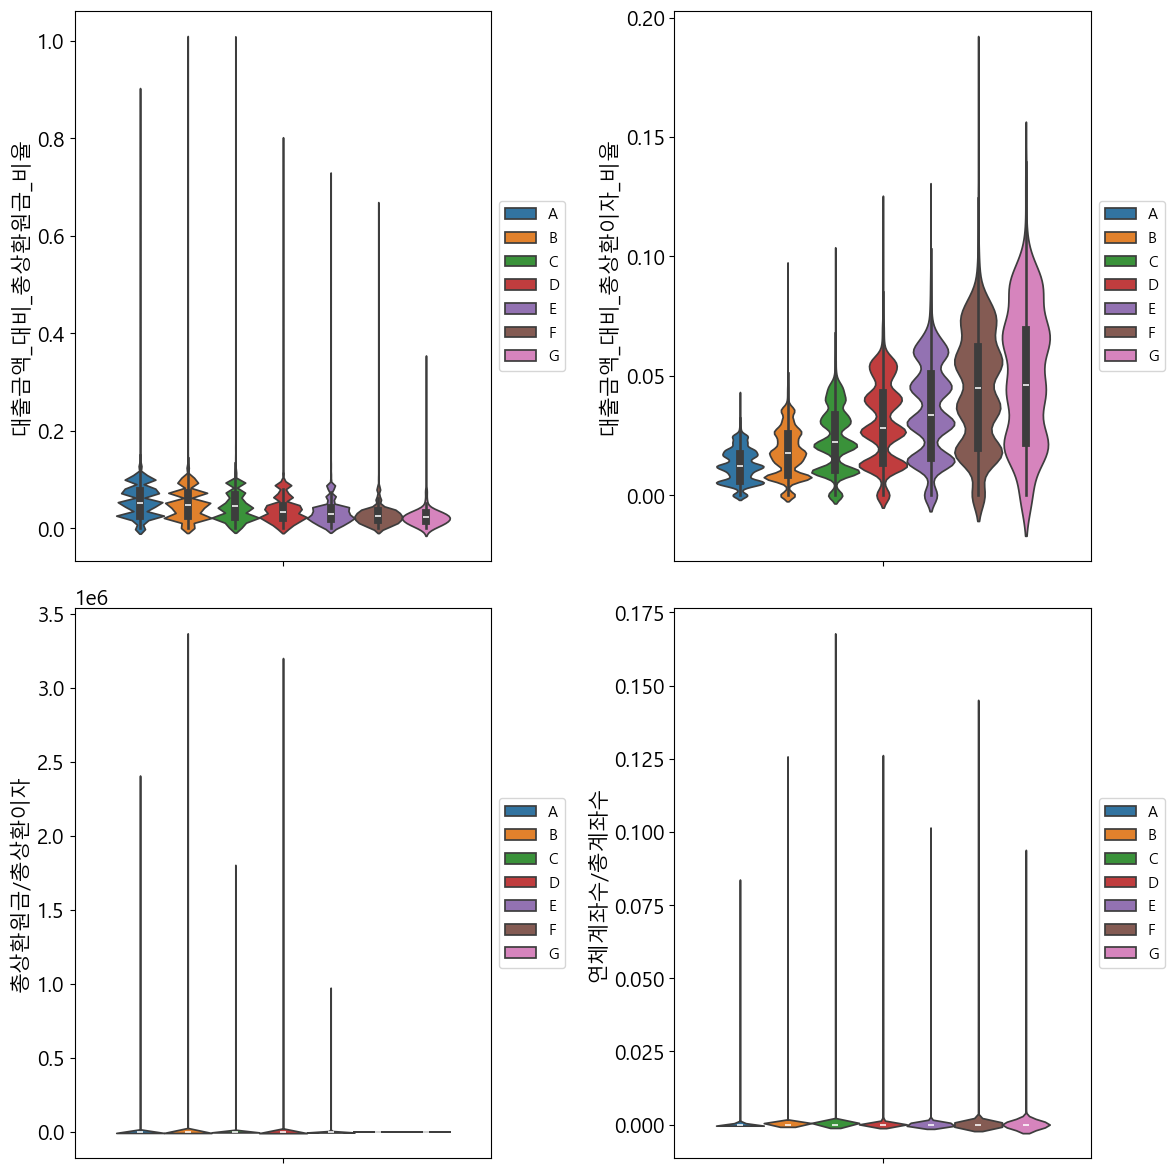

In [37]:
plt.figure(figsize=(12,12))
for idx, feature in tqdm(enumerate(derive_num_col)):
    plt.subplot(2,2,idx+1)
    sns.violinplot(y=derive_num_col[idx], hue = target, data = train_prep, hue_order= order_grade)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=11)
plt.tight_layout()
plt.show()

## 스케일링
- 수동 로그스케일링:
	- 총연체금액: 로그스케일링해주기 ->해보니 결과 너무 이상한듯하여 추가 확인결과 할 필요 없을듯
- 학습 모델을 이용한 스케일링:
	- sd scaler(이상치가 많은 경우):
	- mm scaler(이상치가 거의 없는 경우):

### <strike>수동 로그 스케일링</strike>

총연체금액에 대하여 해주었는데 결과가 너무 이상한듯하여 추가 확인 결과 할 필요 없을듯

### 학습 모델을 이용한 스케일링     
-> 너무 대강 골랐나 하는 생각은 있음 이 부분은 크게 생각안하고 선택
- 수치형 데이터: '대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수'
- 표준화(sd_sc): '연간소득'?, '부채_대비_소득_비율'? ->조금 애매함 튜터님과 상의
- 정규화(mm_sc): '대출금액', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수'

#### 함수화

In [38]:
def get_numeric_sc(data_train:pd.DataFrame = train_prep, data_test:pd.DataFrame = real_test):
    """데이터를 전달받아 수치형 변수 스케일링하는 함수

    Args:
        X_train (pd.DataFrame): train 데이터프레임
        X_test (pd.DataFrame):  test 데이터프레임

    Returns:
        pd.DataFrame, pd.DataFrame: train, test 데이터프레임
    """
    # 수치형변수
    # '대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수'
    # +'대출기간'
    #StandardScaler 적용할 변수 리스트
    sc_col = ['연간소득', '부채_대비_소득_비율', '대출기간'] + derive_num_col
    #MinMaxScaler 적용할 변수 리스트
    mm_col = [num_col for num_col in numeric_col if num_col not in sc_col]
    
    #모델 가져오기
    sd_sc = StandardScaler()
    mm_sc = MinMaxScaler()

    #train, test 데이터변환(Standard Scaler이용)
    sd_sc.fit(data_train[sc_col])
    data_train[sc_col] = sd_sc.transform(data_train[sc_col])  #컬럼추가안해주고 바로 바꾸는지?
    data_test[sc_col] = sd_sc.transform(data_test[sc_col])
    
    #train, test 데이터변환(MinMax Scaler이용)
    mm_sc.fit(data_train[mm_col])
    data_train[mm_col] = mm_sc.transform(data_train[mm_col])
    data_test[mm_col] = mm_sc.transform(data_test[mm_col])
    
    return data_train, data_test

## 인코딩
- y 변수 인코딩: 
- 순서가 중요한 순서형 데이터: (map이나 다른 패키지의 모듈 사용)
- 레이블 인코딩: 대출기간, 근로기간 (순서나 관계가 있는 경우에는 이 두 가지 외의 다른 인코딩을 해주어야할 수도 있는듯 함)
- 원-핫 인코딩 : 주택소유상태, 대출목적
	- get_dummy:
	- 원-핫 인코딩:

### y 변수 인코딩
일단은 dict와 map을 이용해서 인코딩해주었음     
매칭시켜준 값은 y_dict = {'G': 1, 'F': 2, 'E': 3, 'D': 4, 'C': 5, 'B': 6, 'A': 7}로 임시로 해뒀음 -> 더 좋은 아이디어가 있을지?     
굳이 인코딩 안해주고 문자열인 채로 그대로 입력해줄 예정

#### 확인용

#### 딕셔너리 -> 원래 인코딩하여 컬럼에 추가해줄려했으나 그냥 바로 가져다 쓰는 것으로 일단 결정

In [39]:
# # y 변수 인코딩 함수
# # def get_multiple_categories(x):

# # y값 매칭해줄 정보 딕셔너리    
# y_dict = {'G': 1, 'F': 2, 'E': 3, 'D': 4, 'C': 5, 'B': 6, 'A': 7} # {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}
target_dict = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}

### 범주형 데이터 전처리 (인코딩)
from category_encoders 의 OrdinalEncoder 나 binaryEncoder같은 것 사용할 듯		
->좀더 고민을 해보긴 해야할듯
- 범주형 데이터: '대출기간', '근로기간', '주택소유상태', '대출목적'   
우선적으로 그냥 get_dummies로 하고 시간 여유가 된다면 후에 더 건드려볼듯 함	
	
- 순서가 중요한 순서형 데이터 (map이나 다른 패키지의 모듈 사용(from category_encoders import OrdinalEncoder)) : 	
	- 대출기간, 근로기간 정도 생각은 하고 있음
- 레이블 인코딩(le): 대출기간, 근로기간 (순서나 관계가 있는 경우에는 이 두 가지 외의 다른 인코딩을 해주어야할 수도 있는듯 함)
- 원-핫 인코딩(oe): 주택소유상태, 대출목적	
	둘중 하나로 통일해서 전부 해볼 듯하다   
	- get_dummy:
	- 원-핫 인코딩:

In [40]:
train_prep['근로기간'].cat.categories

Index(['Unknown', '< 1 year', '1 year', '2 years', '3 years', '4 years',
       '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years'],
      dtype='object')

#### 함수화

In [41]:
def get_category(data_train:pd.DataFrame = train_prep, data_test:pd.DataFrame = real_test):
    """ 데이터를 전달받아 범주형 변수 더미화하는 함수

    Args:
        X_train (pd.DataFrame): train 데이터프레임
        X_test (pd.DataFrame):  test 데이터프레임
        # 컬럼 리스트를 4가지로 받아서 각 순서, 레이블, get_dummies, 원핫으로 사용할 수 있게 구현시켜볼 예정
    Returns:
        pd.DataFrame, pd.DataFrmae, list: train, test 데이터프레임, 더미화된 컬럼
    """
    # 범주형 변수: '대출기간 X', '근로기간', '주택소유상태', '대출목적'
    oe_cols = ['근로기간']
    be_cols = [cat_col for cat_col in category_col if cat_col not in oe_cols] # ['대출목적','주택소유상태']
    
    # 범주형 컬럼 be하기
    be = ce.BinaryEncoder(cols=be_cols) # handle_unknown='ignore' 기본값 error인데 일단 기본값으로 해봄
    be.fit(data_train[be_cols])
    be_transformed_train = be.transform(data_train[be_cols])  # 애초에 얘도 여러개 생성해서 바로 바꾸는것 안됨
    be_transformed_test = be.transform(data_test[be_cols])
    
    # 원래 DataFrame에서 변환할 열 제거
    # data_train = data_train.drop(be_cols, axis=1)
    # data_test = data_test.drop(be_cols, axis=1)
    
    # 변환된 DataFrame 병합
    data_train = data_train.join(be_transformed_train)
    data_test = data_test.join(be_transformed_test)
    
    # 아래 xgb부분에서 feature_name에 특수기호 들어가면 안된다고 에러가 나서 해당하는 부분 이름 바꿔주기
    # feature_name에 특수기호 + <등 들어가 에러가나서 (get_dummies하는 부분에서 추가된 컬럼들)
    # 나중에 해당부분 get_dummies로 안할경우를 대비해 조건문 등으로 이런 컬럼이 있을 때만 이름을 바꿔주게 설정해줘야함
    # if ('근로기간_<1 year' in train_dummies.columns) or ('근로기간_10+ years' in train_dummies.columns):
    #     rename_dict = {
    #         '근로기간_<1 year': '근로기간_less_1 year',
    #         '근로기간_10+ years': '근로기간_10_more years'
    #     }
    
    # oe1 = OrdinalEncoder(categories=[[' 36 months', ' 60 months']],handle_unknown='error')
    oe2 = OrdinalEncoder(categories=[['Unknown', '< 1 year', '1 year', '2 years', '3 years', '4 years','5 years', 
                                      '6 years', '7 years', '8 years', '9 years', '10+ years']],handle_unknown='error')
        
    # data_train['대출기간'] = oe1.fit_transform(data_train[['대출기간']])
    data_train['근로기간'] = oe2.fit_transform(data_train[['근로기간']])
    # data_test['대출기간'] = oe1.transform(data_test[['대출기간']])
    data_test['근로기간'] = oe2.transform(data_test[['근로기간']])
    #.astype(int) 로 타입 int로 바꾸는 것도 생각
    
    return data_train, data_test, oe_cols+be_transformed_train.columns.to_list()

'''['대출기간_ 36 months','대출기간_ 60 months','근로기간_Unknown','근로기간_less_1 year','근로기간_1 year',
                             '근로기간_2 years','근로기간_3 years','근로기간_4 years','근로기간_5 years','근로기간_6 years','근로기간_7 years',
                             '근로기간_8 years','근로기간_9 years','근로기간_10_more years','주택소유상태_MORTGAGE','주택소유상태_OWN',
                             '주택소유상태_RENT','대출목적_기타','대출목적_부채 통합','대출목적_소규모 사업','대출목적_신용 카드','대출목적_의료',
                             '대출목적_이사','대출목적_자동차','대출목적_재생 에너지','대출목적_주요 구매','대출목적_주택','대출목적_주택 개선',
                             '대출목적_휴가','최근_2년간_연체_여부_no','최근_2년간_연체_여부_yes','연체_여부(총금액)_no','연체_여부(총금액)_yes',
                             '연체_여부(계좌수)_no','연체_여부(계좌수)_yes']'''

### <strike>train 데이터 train과 test데이터로 분리</strike> 
-> 굳이 X_train, X_test, y_train, y_test 형태로 나눌 필요 없을듯
kfold나 cross_val_score나 GridSearchCV, RandomizedSearchCV를 사용방식 선택

# 모델 수립 및 평가
- 모델은 후보로 염두 중인 것은 로지스터 회귀, 의사결정나무, 랜덤포레스트, knn(최근접이웃), Gradient Boosting, XGBoost, LightGBM     
    ['lor', 'dt', 'rf', 'knn', 'gbm', 'xgb', 'lgb']
- 우선 일반적으로 이진분류에서 사용하는 평가지표인 <u>정확도</u>, 정밀도, 재현율, <u>F1 점수</u> 사용을 할 것이지만 
    보통 다중 분류에서는 각 클래스에 대한 지표를 계산한 후 평균 내는 방법 등이 추가로 필요하다고 하여 추가 조사 필요
- 전체적으로 다중 분류의 경우 아래와 같이 본 설명이 있어 추가로 이진분류와 어떻게 추가로 다르게 해줘야하는지는 찾아보아야 함
    * 레이블 처리: 이진 분류에서는 대상 변수가 두 가지 범주로 나뉘지만, 다중 분류에서는 대상 변수가 세 개 이상의 범주로 나뉩니다. 따라서 다중 분류 문제에서는 레이블을 적절히 처리해야 합니다.    
    * 성능 측정: 이진 분류에서는 정확도, 정밀도, 재현율, F1 점수 등을 사용하여 모델의 성능을 측정합니다. 다중 분류에서도 이러한 지표를 사용할 수 있지만, 각 클래스에 대한 지표를 계산한 후 이를 평균내는 방법 등이 추가로 필요합니다.     
    * 확률 추정: 일부 알고리즘(예: 로지스틱 회귀)은 이진 분류에서는 시그모이드 함수를, 다중 분류에서는 소프트맥스 함수를 사용하여 클래스 확률을 추정합니다.
    * 손실 함수: 일부 알고리즘(예: SVM, 신경망)은 이진 분류와 다중 분류에서 다른 손실 함수를 사용합니다.

rt의 경우 변수별 중요도를 추출할 수 있어서 그것을 통해 그래프 그리는 기능 추가시켜뒀음

## 모델 적용 및 평가 함수
아마 그러면 이것도 대대적인 공사를 해야할 것 같음       
지금 같은 형태에서 한번에? 패키지 써서 비교하는 식으로 해야할듯

### 커스텀 스코어

In [42]:
# 중간 진행도 알기 위해서 커스텀 스코어 만들어줌
from sklearn.metrics import f1_score, make_scorer
from datetime import datetime
def custom_f1_macro(y_true, y_pred):
    # f1_macro 점수 계산
    score = f1_score(y_true, y_pred, average='macro')
    
    # 현재 시간과 점수 출력
    current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"{current_time} Score: {score}")
    
    return score

# 커스텀 스코어러 생성
custom_scorer_f1 = make_scorer(custom_f1_macro)

### cross_validate 이용 모델 평가함수

In [55]:
def model_evaluation(data_train:pd.DataFrame, x_var_list:list):
    """ train과 test 데이터와 X변수 컬럼을 받아 평가지표를 내는 함수입니다.

    Args:
        train (pd.DataFrame): train 데이터프레임
        test (pd.DataFrame): test 데이터프레임
        x_var_list (list): 모델링에 사용할 변수 리스트
        model_type(str) : 무슨 모델 쓸지 결정 (default : 'rf')
    """
    # 모델 생성
    '''model_list = {'model_lor': LogisticRegression(), 'model_dt': DecisionTreeClassifier(random_state=42), 
                'model_rf': RandomForestClassifier(random_state=42), 'model_knn': KNeighborsClassifier(), 
                'model_gbm': GradientBoostingClassifier(random_state= 42), 
                'model_xgb': XGBClassifier(objective='multi:softmax', random_state= 42, eval_metric=['merror', 'mlogloss']), 
                'model_lgb': LGBMClassifier(random_state= 42), 'model_et': ExtraTreesClassifier(random_state=42)}'''
                
    model_list = {'model_dt': DecisionTreeClassifier(random_state=42, max_depth=18, criterion='entropy'), 
                'model_rf': RandomForestClassifier(random_state=42, min_samples_leaf=1, n_estimators=100, min_samples_split=8, max_depth=44, criterion='gini'), 
                'model_xgb': XGBClassifier(random_state=42, reg_lambda = 0.046, reg_alpha = 0.88, tree_method='exact', subsample=0.7,
                        n_estimators=700, min_child_weight=2, max_depth=67, learning_rate=0.39999999999999997, colsample_bytree=0.635593220338983, eval_metric=['merror']), # , 'mlogloss'
                'model_et': ExtraTreesClassifier(random_state=42, min_samples_leaf = 1, n_estimators=600, min_samples_split=5, max_depth=49, criterion='entropy')}
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # 평가지표 설정
    scoring_list = ['accuracy', 'f1_macro']
    results = {}
    fit_model_list={}
    for model_name, model in tqdm(model_list.items()):
        print(f"{name}하는 중")
        result = cross_validate(estimator=model, X=data_train[x_var_list], y=data_train[target].replace(target_dict), scoring=scoring_list, cv=kf, return_train_score=True, verbose=3)
        results[model_name] = result
        # 모델 복제 및 학습
        model_clone = clone(model)
        model_clone.fit(data_train[x_var_list], data_train[target].replace(target_dict))
        # 학습된 모델 저장
        fit_model_list[model_name] = model_clone
    return results, fit_model_list

### GridSearchCV

In [44]:
def grid_search(data_train:pd.DataFrame, x_var_list:list):
    # 모델들과 하이퍼파라미터 그리드 정의
    models = {
        'model_dt': (DecisionTreeClassifier(random_state=42, criterion='entropy'), {'max_depth': [16, 18]}),
        'model_rf': (RandomForestClassifier(random_state=42, min_samples_leaf=1, n_estimators=100, criterion='gini'), 
                     {'min_samples_split': [5, 8], 'max_depth': [44, 59]}),
        'model_et': (ExtraTreesClassifier(random_state=42, min_samples_leaf = 1, n_estimators=600, min_samples_split=5), 
                     {'criterion': ['entropy', 'gini'], 'max_depth': [49, 59]}),
        'model_xgb': (XGBClassifier(max_depth=67, random_state=42, reg_alpha = 0.88, reg_lambda = 0.046, tree_method='exact'), 
                      {'colsample_bytree': [0.635593220338983, 0.6779661016949152], 'learning_rate': [0.3, 0.39999999999999997], 
                       'min_child_weight': [2, 3], 'n_estimators': [50, 700], 'subsample': [0.7, 1.0]}),
    }
    #'model_lgb': (LGBMClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]}), 뭔가 너무 경고나오고 그래서 제외시켜줌
    # 각 모델에 대해 그리드 서치 및 교차 검증 수행
    results = {}
    best_models = {}  # 최적의 모델 저장을 위한 딕셔너리
    cv_results = {}  # cv_results를 저장할 딕셔너리
    scoring ={
        'f1_macro': make_scorer(custom_f1_macro),
        'accuracy': 'accuracy'
    }
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for name, (model, param_grid) in tqdm(models.items()):
        print(f"{name}하는 중")
        grid_search = GridSearchCV(model, param_grid, cv=kf, scoring=scoring, refit='f1_macro', verbose=4)
        grid_search.fit(data_train[x_var_list], data_train[target].replace(target_dict))
        results[name] = {
            'best_params': grid_search.best_params_,
            'best_f1_score': grid_search.cv_results_['mean_test_f1_macro'][grid_search.best_index_],
            'best_accuracy': grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_],
            'best_scores': grid_search.best_score_, # f1_score 의미
        }
        best_models[name] = grid_search.best_estimator_  # 최적의 모델 저장
        cv_results[name] = grid_search.cv_results_  # cv_results 저장

    # for name, result in results.items():
    #     print(type(result['best_scores']))  # 자료형 확인
    
    # 결과 출력
    for name, result in results.items():
        print(f"Model: {name}")
        print(f"Best Parameters: {result['best_params']}")
        print(f"Best F1-macro Score: {result['best_f1_score']}")
        print(f"Best Accuracy Score: {result['best_accuracy']}")
        print(f"Best Score: {result['best_scores']}")
        print()
    return grid_search, results, best_models, cv_results

### RandomizeSearchCV

In [45]:
def random_search(data_train:pd.DataFrame, x_var_list:list):
    # 모델들과 하이퍼파라미터 그리드 정의
    models = {
        'model_dt': (DecisionTreeClassifier(random_state=42), {'criterion': ['gini','entropy'], 'max_depth': np.arange(15, 40)}),
        'model_rf': (RandomForestClassifier(random_state=42, min_samples_leaf=1), 
                     {'criterion': ['gini','entropy'], 'n_estimators': [50, 100, 310], 'max_depth': np.arange(40, 70), 'min_samples_split' : np.arange(2, 10)}),
        'model_et': (ExtraTreesClassifier(random_state=42, min_samples_leaf = 1), 
                     {'criterion': ['gini','entropy'], 'n_estimators': [50, 600, 950], 'max_depth': np.arange(40, 70), 'min_samples_split' : np.arange(2, 10)}),
        'model_xgb': (XGBClassifier(random_state=42, reg_lambda = 0.046, reg_alpha = 0.88, colsample_bytree = 0.766), 
                      {'tree_method': ['exact','approx','auto'], 'n_estimators': [50, 100, 700], 'max_depth': np.arange(60, 70), 
                       'colsample_bytree': np.linspace(0.5, 1, num=60),'subsample': np.linspace(0.5, 1, num=6),
                       'learning_rate': np.linspace(0.3,0.6,num=4), 'min_child_weight': np.arange(1,4)}),
    }
    #'model_lgb': (LGBMClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]}), 뭔가 너무 경고나오고 그래서 제외시켜줌
    # 각 모델에 대해 그리드 서치 및 교차 검증 수행
    results = {}
    best_models = {}  # 최적의 모델 저장을 위한 딕셔너리
    cv_results = {}  # cv_results를 저장할 딕셔너리
    scoring ={
        'f1_macro': 'f1_macro', # make_scorer(custom_f1_macro),
        'accuracy': 'accuracy'
    }
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for name, (model, param_grid) in tqdm(models.items()):
        print(f"{name}하는 중")
        random_search = RandomizedSearchCV(model, param_grid, cv=kf, scoring=scoring, refit='f1_macro', n_iter=100, verbose=4, random_state=42)
        random_search.fit(data_train[x_var_list], data_train[target].replace(target_dict))
        results[name] = {
            'best_params': random_search.best_params_,
            'best_f1_score': random_search.cv_results_['mean_test_f1_macro'][random_search.best_index_],
            'best_accuracy': random_search.cv_results_['mean_test_accuracy'][random_search.best_index_],
            'best_scores': random_search.best_score_, # f1_score 의미
        }
        best_models[name] = random_search.best_estimator_  # 최적의 모델 저장
        cv_results[name] = random_search.cv_results_  # cv_results 저장

    # for name, result in results.items():
    #     print(type(result['best_scores']))  # 자료형 확인
    
    # 결과 출력
    for name, result in results.items():
        print(f"Model: {name}")
        print(f"Best Parameters: {result['best_params']}")
        print(f"Best F1-macro Score: {result['best_f1_score']}")
        print(f"Best Accuracy Score: {result['best_accuracy']}")
        print(f"Best Score: {result['best_scores']}")
        print()
    return random_search, results, best_models, cv_results

### 특성 중요도

In [46]:
def feature_importance(model_list:dict, remove_keys=['model_dt'], data_train:pd.DataFrame = train_prep, x_var_list:list=numeric_col):
    # 'model_dt' 제외
    model_list = {k: v for k, v in model_list.items() if k not in remove_keys}
    X = data_train[x_var_list]
    # 제외한 모델에 대해 특성 중요도 계산 및 시각화
    for model_name, model in tqdm(model_list.items()):
        importances = model.feature_importances_
        indices = np.argsort(importances)

        # plt.figure(figsize=(10,6))
        # plt.title(f"Feature importances of {model_name}")
        # plt.bar(range(X.shape[1]), importances[indices],color="r", align="center")
        # feature_names = [x_var_list[i] for i in indices]
        # plt.xticks(range(X.shape[1]), feature_names, rotation='vertical')
        # plt.xlim([-1, X.shape[1]])
        # plt.show()
        
        plt.figure(figsize=(10,6))
        plt.title(f"Feature importances of '{model_name}' ")
        bars = plt.barh(range(X.shape[1]), importances[indices], color="r", align="center")
        plt.yticks(range(X.shape[1]), X.columns[indices])
        plt.ylim([-1, X.shape[1]])
        # 각 막대 끝에 중요도 값을 표시
        for bar in bars:
            width = bar.get_width()
            plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.3f}', ha='left', va='center')
        plt.show()

### RFECV

In [47]:
def rfe(data_train:pd.DataFrame, x_var_list:list, models:dict):
    feature_infos = {}  # 특성 정보를 저장할 딕셔너리
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # 각 모델에 대해 RFECV 적용
    for model_name, model in tqdm(models.items()):
        print(f"Model: {model_name}")
        rfecv = RFECV(estimator=model, step=1, cv=kf, verbose=3, scoring='f1_macro') # scoring=custom_scorer_f1
        rfecv.fit(data_train[x_var_list], data_train[target].replace(target_dict))

        print(f"Optimal number of features for {model_name} : {rfecv.n_features_}")

        # 특성 정보 저장
        feature_info = {
            'support': rfecv.support_,
            'ranking': rfecv.ranking_,
            'n_features': rfecv.n_features_
        }
        feature_infos[model_name] = feature_info
        # 특성 중요도 순위 출력
        ranking = sorted(zip(map(lambda x: round(x, 4), rfecv.ranking_), x_var_list), reverse=False)
        print("Features sorted by their rank:")
        print(ranking)

    return rfecv, feature_infos

### stacking

In [48]:
def stacking_clf(data_train:pd.DataFrame, x_var_list:list):
    # 모델들과 하이퍼파라미터 그리드 정의
    dt = DecisionTreeClassifier(random_state=42, max_depth=18, criterion='entropy')
    rf = RandomForestClassifier(random_state=42, min_samples_leaf=1, n_estimators=100, min_samples_split=8, max_depth=44, criterion='gini')
    et = ExtraTreesClassifier(random_state=42, min_samples_leaf = 1, n_estimators=600, min_samples_split=5, max_depth=49, criterion='entropy')
    xgb = XGBClassifier(random_state=42, reg_lambda = 0.046, reg_alpha = 0.88, tree_method='exact', subsample=0.7,
                        n_estimators=700, min_child_weight=2, max_depth=67, learning_rate=0.39999999999999997, colsample_bytree=0.635593220338983)
   
    base_estimators =[('model_dt',dt),('model_rf',rf),('model_et',et),('model_xgb',xgb)]
    stacking_model = StackingClassifier(estimators=base_estimators, final_estimator=LogisticRegression(), verbose=4)
    stacking_model.fit(data_train[x_var_list], data_train[target].replace(target_dict))
    
    return stacking_model

## 전체 모델링 및 평가
- 하기전에 전처리등 test 데이터에도 동일하게 해줬는지 생각(결측치 등은 몇몇부분은 안해줘야할 것 같기도한데 그부분은 좀더 고민)

### 위에서 만들어 둔 스케일링과 인코딩 적용

In [49]:
train_prep, real_test = get_numeric_sc(train_prep, real_test)
train_prep, real_test, category_en_cols = get_category(train_prep, real_test)

##### 확인용

In [50]:
# pd.set_option('display.max_columns', None)
# display(train_prep)
# print(be_columns)
# real_test

### 특성 선택

In [51]:
numeric_col+category_en_cols

['대출금액',
 '연간소득',
 '부채_대비_소득_비율',
 '총계좌수',
 '최근_2년간_연체_횟수',
 '총상환원금',
 '총상환이자',
 '총연체금액',
 '연체계좌수',
 '대출기간',
 '대출금액_대비_총상환원금_비율',
 '대출금액_대비_총상환이자_비율',
 '총상환원금/총상환이자',
 '연체계좌수/총계좌수',
 '근로기간',
 '주택소유상태_0',
 '주택소유상태_1',
 '주택소유상태_2',
 '대출목적_0',
 '대출목적_1',
 '대출목적_2',
 '대출목적_3']

In [52]:
selected_features = ['대출기간', '대출금액_대비_총상환원금_비율', '대출금액_대비_총상환이자_비율', '총상환원금/총상환이자']
# ['연간소득', '부채_대비_소득_비율', '대출기간', '대출금액_대비_총상환원금_비율', 
#                      '대출금액_대비_총상환이자_비율', '총상환원금/총상환이자']# numeric_col+category_en_cols

### 모델별 학습 및 평가

In [57]:
# model_evaluation_results, evaluation_model_list = model_evaluation(train_prep, selected_features) #일단 위에서 범주형 컬럼 추가해준 부분은 포함안해줬음
model_evaluation_results, evaluation_model_list = model_evaluation(train_prep, ['대출기간', '대출금액_대비_총상환원금_비율', '대출금액_대비_총상환이자_비율'])

  0%|          | 0/4 [00:00<?, ?it/s]

[CV] END  accuracy: (train=0.964, test=0.951) f1_macro: (train=0.967, test=0.950) total time=   0.1s
[CV] END  accuracy: (train=0.964, test=0.951) f1_macro: (train=0.967, test=0.947) total time=   0.1s
[CV] END  accuracy: (train=0.963, test=0.952) f1_macro: (train=0.967, test=0.948) total time=   0.1s
[CV] END  accuracy: (train=0.964, test=0.952) f1_macro: (train=0.967, test=0.952) total time=   0.1s
[CV] END  accuracy: (train=0.964, test=0.951) f1_macro: (train=0.968, test=0.940) total time=   0.1s


 25%|██▌       | 1/4 [00:01<00:04,  1.34s/it]

[CV] END  accuracy: (train=0.960, test=0.954) f1_macro: (train=0.961, test=0.952) total time=   6.1s
[CV] END  accuracy: (train=0.960, test=0.953) f1_macro: (train=0.962, test=0.943) total time=   6.1s
[CV] END  accuracy: (train=0.960, test=0.955) f1_macro: (train=0.960, test=0.951) total time=   6.2s
[CV] END  accuracy: (train=0.960, test=0.954) f1_macro: (train=0.961, test=0.951) total time=   6.2s
[CV] END  accuracy: (train=0.961, test=0.951) f1_macro: (train=0.962, test=0.941) total time=   6.0s


 50%|█████     | 2/4 [00:43<00:50, 25.21s/it]

[CV] END  accuracy: (train=0.963, test=0.951) f1_macro: (train=0.967, test=0.950) total time=  43.3s
[CV] END  accuracy: (train=0.963, test=0.950) f1_macro: (train=0.967, test=0.939) total time=  43.0s
[CV] END  accuracy: (train=0.963, test=0.953) f1_macro: (train=0.966, test=0.951) total time=  43.2s
[CV] END  accuracy: (train=0.963, test=0.951) f1_macro: (train=0.966, test=0.947) total time=  43.5s
[CV] END  accuracy: (train=0.964, test=0.949) f1_macro: (train=0.968, test=0.940) total time=  43.4s


 75%|███████▌  | 3/4 [05:20<02:20, 140.48s/it]

[CV] END  accuracy: (train=0.963, test=0.953) f1_macro: (train=0.966, test=0.948) total time=  13.9s
[CV] END  accuracy: (train=0.963, test=0.951) f1_macro: (train=0.966, test=0.942) total time=  13.7s
[CV] END  accuracy: (train=0.963, test=0.954) f1_macro: (train=0.966, test=0.949) total time=  14.0s
[CV] END  accuracy: (train=0.963, test=0.953) f1_macro: (train=0.965, test=0.952) total time=  14.1s
[CV] END  accuracy: (train=0.963, test=0.950) f1_macro: (train=0.967, test=0.936) total time=  13.8s


100%|██████████| 4/4 [07:16<00:00, 109.06s/it]


In [54]:
model_evaluation_results

{'model_dt': {'fit_time': array([0.73709822, 0.75192523, 0.70924449, 0.71300268, 0.71342373]),
  'score_time': array([0.01201153, 0.01301217, 0.01201177, 0.01301193, 0.01201105]),
  'test_accuracy': array([0.83148709, 0.83007629, 0.83304593, 0.83299368, 0.8375921 ]),
  'train_accuracy': array([1., 1., 1., 1., 1.]),
  'test_f1_macro': array([0.76804916, 0.76297899, 0.76968076, 0.76130492, 0.77209298]),
  'train_f1_macro': array([1., 1., 1., 1., 1.])},
 'model_rf': {'fit_time': array([17.55468202, 17.73085928, 17.19782639, 17.21756482, 17.10918355]),
  'score_time': array([0.51496935, 0.48344135, 0.44927716, 0.46242046, 0.4416728 ]),
  'test_accuracy': array([0.78409447, 0.79093949, 0.78376966, 0.78565083, 0.79009249]),
  'train_accuracy': array([1., 1., 1., 1., 1.]),
  'test_f1_macro': array([0.64571579, 0.65811246, 0.63755548, 0.63924503, 0.65881169]),
  'train_f1_macro': array([1., 1., 1., 1., 1.])},
 'model_xgb': {'fit_time': array([1.60232568, 1.2642107 , 1.28456974, 1.34851193, 1.3

In [51]:
evaluation_model_list

{'model_dt': DecisionTreeClassifier(random_state=42),
 'model_rf': RandomForestClassifier(random_state=42),
 'model_xgb': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=['merror', 'mlogloss'],
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, objective='multi:softmax', ...),
 'model_et': ExtraTreesClassifier(random_state=42)}

In [61]:
print(evaluation_model_list['model_dt'].tree_.max_depth)
print(max([estimator.tree_.max_depth for estimator in evaluation_model_list['model_rf'].estimators_]))
print(evaluation_model_list['model_rf'].n_estimators)
print(max([estimator.tree_.max_depth for estimator in evaluation_model_list['model_et'].estimators_]))
print(evaluation_model_list['model_et'].n_estimators)
print(evaluation_model_list['model_xgb'].n_estimators)

50
44
100
56
100
None


### grid

In [74]:
grid_search_model, grid_search_results, grid_search_best_models, grid_search_cv_results = grid_search(train_prep, selected_features)

  0%|          | 0/4 [00:00<?, ?it/s]

model_dt하는 중
Fitting 5 folds for each of 2 candidates, totalling 10 fits
2024-02-17 23:01:48 Score: 0.9495301422183234
[CV 1/5] END max_depth=16; accuracy: (test=0.951) f1_macro: (test=0.950) total time=   0.2s
2024-02-17 23:01:48 Score: 0.9380371777301943
[CV 2/5] END max_depth=16; accuracy: (test=0.950) f1_macro: (test=0.938) total time=   0.2s
2024-02-17 23:01:49 Score: 0.9455842192755305
[CV 3/5] END max_depth=16; accuracy: (test=0.952) f1_macro: (test=0.946) total time=   0.1s
2024-02-17 23:01:49 Score: 0.9444248347746039
[CV 4/5] END max_depth=16; accuracy: (test=0.951) f1_macro: (test=0.944) total time=   0.1s
2024-02-17 23:01:49 Score: 0.9367850861941055
[CV 5/5] END max_depth=16; accuracy: (test=0.949) f1_macro: (test=0.937) total time=   0.2s
2024-02-17 23:01:49 Score: 0.9517670190536747
[CV 1/5] END max_depth=18; accuracy: (test=0.951) f1_macro: (test=0.952) total time=   0.2s
2024-02-17 23:01:50 Score: 0.9377658691937868
[CV 2/5] END max_depth=18; accuracy: (test=0.950) f1_

 25%|██▌       | 1/4 [00:02<00:08,  2.84s/it]

model_rf하는 중
Fitting 5 folds for each of 4 candidates, totalling 20 fits
2024-02-17 23:01:59 Score: 0.9518514963432941
[CV 1/5] END max_depth=44, min_samples_split=5; accuracy: (test=0.953) f1_macro: (test=0.952) total time=   8.4s
2024-02-17 23:02:08 Score: 0.943138164099884
[CV 2/5] END max_depth=44, min_samples_split=5; accuracy: (test=0.952) f1_macro: (test=0.943) total time=   8.4s
2024-02-17 23:02:16 Score: 0.9493637756322657
[CV 3/5] END max_depth=44, min_samples_split=5; accuracy: (test=0.954) f1_macro: (test=0.949) total time=   8.4s
2024-02-17 23:02:25 Score: 0.9520526160675545
[CV 4/5] END max_depth=44, min_samples_split=5; accuracy: (test=0.953) f1_macro: (test=0.952) total time=   8.4s
2024-02-17 23:02:33 Score: 0.9388235021808876
[CV 5/5] END max_depth=44, min_samples_split=5; accuracy: (test=0.951) f1_macro: (test=0.939) total time=   8.5s
2024-02-17 23:02:42 Score: 0.9516161881239388
[CV 1/5] END max_depth=44, min_samples_split=8; accuracy: (test=0.953) f1_macro: (test=

 50%|█████     | 2/4 [03:02<03:33, 106.96s/it]

model_et하는 중
Fitting 5 folds for each of 4 candidates, totalling 20 fits
2024-02-17 23:05:06 Score: 0.9507685600646695
[CV 1/5] END criterion=entropy, max_depth=49; accuracy: (test=0.953) f1_macro: (test=0.951) total time=  15.8s
2024-02-17 23:05:22 Score: 0.9414515840420933
[CV 2/5] END criterion=entropy, max_depth=49; accuracy: (test=0.951) f1_macro: (test=0.941) total time=  15.7s
2024-02-17 23:05:38 Score: 0.9458473410105481
[CV 3/5] END criterion=entropy, max_depth=49; accuracy: (test=0.954) f1_macro: (test=0.946) total time=  15.9s
2024-02-17 23:05:54 Score: 0.9492523641102828
[CV 4/5] END criterion=entropy, max_depth=49; accuracy: (test=0.952) f1_macro: (test=0.949) total time=  15.9s
2024-02-17 23:06:10 Score: 0.935939896093459
[CV 5/5] END criterion=entropy, max_depth=49; accuracy: (test=0.950) f1_macro: (test=0.936) total time=  15.7s
2024-02-17 23:06:26 Score: 0.950700186679729
[CV 1/5] END criterion=entropy, max_depth=59; accuracy: (test=0.953) f1_macro: (test=0.951) total 

 75%|███████▌  | 3/4 [08:39<03:31, 212.00s/it]

model_xgb하는 중
Fitting 5 folds for each of 32 candidates, totalling 160 fits
2024-02-17 23:10:34 Score: 0.9528307257452241
[CV 1/5] END colsample_bytree=0.635593220338983, learning_rate=0.3, min_child_weight=2, n_estimators=50, subsample=0.7; accuracy: (test=0.953) f1_macro: (test=0.953) total time=   6.0s
2024-02-17 23:10:40 Score: 0.9453916605287966
[CV 2/5] END colsample_bytree=0.635593220338983, learning_rate=0.3, min_child_weight=2, n_estimators=50, subsample=0.7; accuracy: (test=0.952) f1_macro: (test=0.945) total time=   6.1s
2024-02-17 23:10:46 Score: 0.9511782257103585
[CV 3/5] END colsample_bytree=0.635593220338983, learning_rate=0.3, min_child_weight=2, n_estimators=50, subsample=0.7; accuracy: (test=0.954) f1_macro: (test=0.951) total time=   5.9s
2024-02-17 23:10:52 Score: 0.9532807548889572
[CV 4/5] END colsample_bytree=0.635593220338983, learning_rate=0.3, min_child_weight=2, n_estimators=50, subsample=0.7; accuracy: (test=0.953) f1_macro: (test=0.953) total time=   5.9s


100%|██████████| 4/4 [1:09:14<00:00, 1038.71s/it]

Model: model_dt
Best Parameters: {'max_depth': 18}
Best F1-macro Score: 0.9430135747867038
Best Accuracy Score: 0.9507456596424569
Best Score: 0.9430135747867038

Model: model_rf
Best Parameters: {'max_depth': 44, 'min_samples_split': 8}
Best F1-macro Score: 0.9477164467194635
Best Accuracy Score: 0.9528149047208994
Best Score: 0.9477164467194635

Model: model_et
Best Parameters: {'criterion': 'entropy', 'max_depth': 49}
Best F1-macro Score: 0.9446519490642105
Best Accuracy Score: 0.9518847912243487
Best Score: 0.9446519490642105

Model: model_xgb
Best Parameters: {'colsample_bytree': 0.635593220338983, 'learning_rate': 0.39999999999999997, 'min_child_weight': 2, 'n_estimators': 700, 'subsample': 0.7}
Best F1-macro Score: 0.9513273108669399
Best Accuracy Score: 0.9529403178656576
Best Score: 0.9513273108669399



In [75]:
grid_search_results

{'model_dt': {'best_params': {'max_depth': 18},
  'best_f1_score': 0.9430135747867038,
  'best_accuracy': 0.9507456596424569,
  'best_scores': 0.9430135747867038},
 'model_rf': {'best_params': {'max_depth': 44, 'min_samples_split': 8},
  'best_f1_score': 0.9477164467194635,
  'best_accuracy': 0.9528149047208994,
  'best_scores': 0.9477164467194635},
 'model_et': {'best_params': {'criterion': 'entropy', 'max_depth': 49},
  'best_f1_score': 0.9446519490642105,
  'best_accuracy': 0.9518847912243487,
  'best_scores': 0.9446519490642105},
 'model_xgb': {'best_params': {'colsample_bytree': 0.635593220338983,
   'learning_rate': 0.39999999999999997,
   'min_child_weight': 2,
   'n_estimators': 700,
   'subsample': 0.7},
  'best_f1_score': 0.9513273108669399,
  'best_accuracy': 0.9529403178656576,
  'best_scores': 0.9513273108669399}}

In [77]:
grid_search_best_models

{'model_dt': DecisionTreeClassifier(criterion='entropy', max_depth=18, random_state=42),
 'model_rf': RandomForestClassifier(max_depth=44, min_samples_split=8, random_state=42),
 'model_et': ExtraTreesClassifier(criterion='entropy', max_depth=49, min_samples_split=5,
                      n_estimators=600, random_state=42),
 'model_xgb': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.635593220338983, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.39999999999999997,
               max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=67, max_leaves=None,
               min_child_weight=2, missing=nan, monotone_con

In [82]:
grid_search_best_models['model_dt'].get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 18,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [78]:
grid_search_model.cv_results_

{'mean_fit_time': array([ 6.01393209,  6.22170892, 49.69304004, 26.82225041,  6.14467473,
         6.25785193, 51.74502544, 29.63245411,  6.33669481,  6.23049264,
        47.74769254, 23.41402311,  5.92702184,  6.06329279, 48.30297384,
        25.16099257,  6.43647718,  6.67440066, 52.37972441, 27.56151218,
         6.22817297,  6.44887242, 51.93177524, 30.21094952,  6.17207532,
         6.28979049, 48.36973348, 23.15545254,  5.99876356,  6.14195209,
        49.08283467, 26.04723148]),
 'std_fit_time': array([0.07811987, 0.1687495 , 0.24366225, 1.05468101, 0.08835316,
        0.07931462, 1.02264978, 1.29669432, 0.19173079, 0.13436479,
        0.25575498, 0.79413161, 0.05242677, 0.08003576, 0.6556918 ,
        1.23669466, 0.14610312, 0.18494029, 0.50925503, 0.70740115,
        0.05714246, 0.06218711, 0.96420578, 1.68773669, 0.05548771,
        0.03661962, 0.22483408, 1.08638876, 0.08117669, 0.052618  ,
        0.89335305, 1.93159003]),
 'mean_score_time': array([0.04043875, 0.0474431 , 

### 특성 중요도 1

  0%|          | 0/3 [00:00<?, ?it/s]

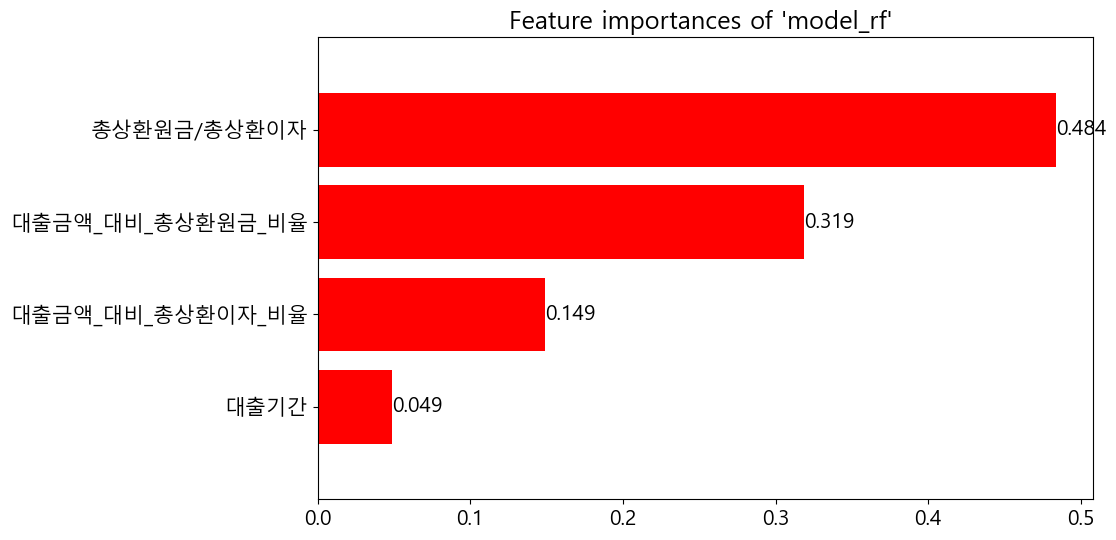

 33%|███▎      | 1/3 [00:00<00:00,  9.94it/s]

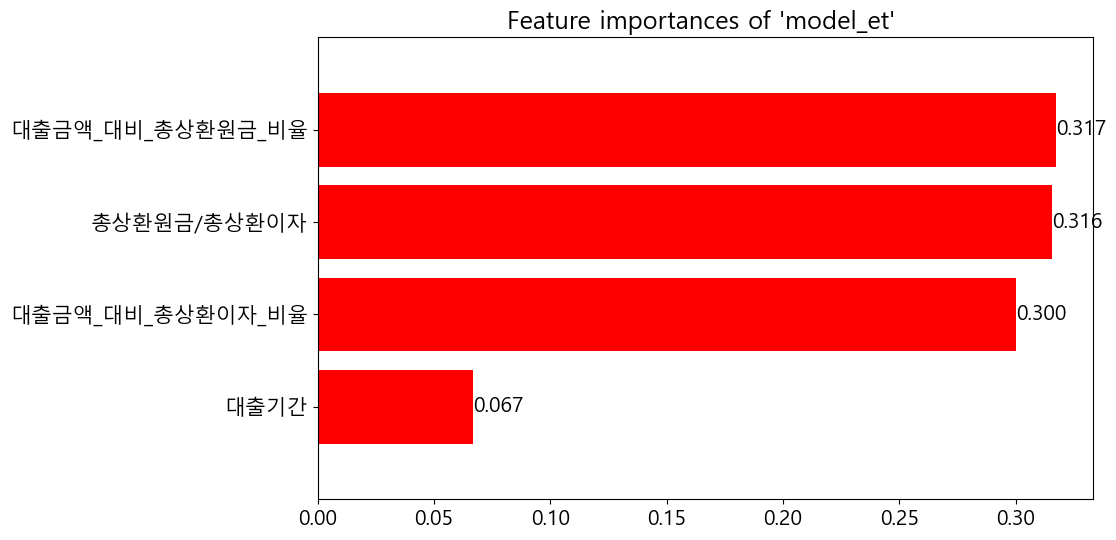

 67%|██████▋   | 2/3 [00:00<00:00,  7.81it/s]

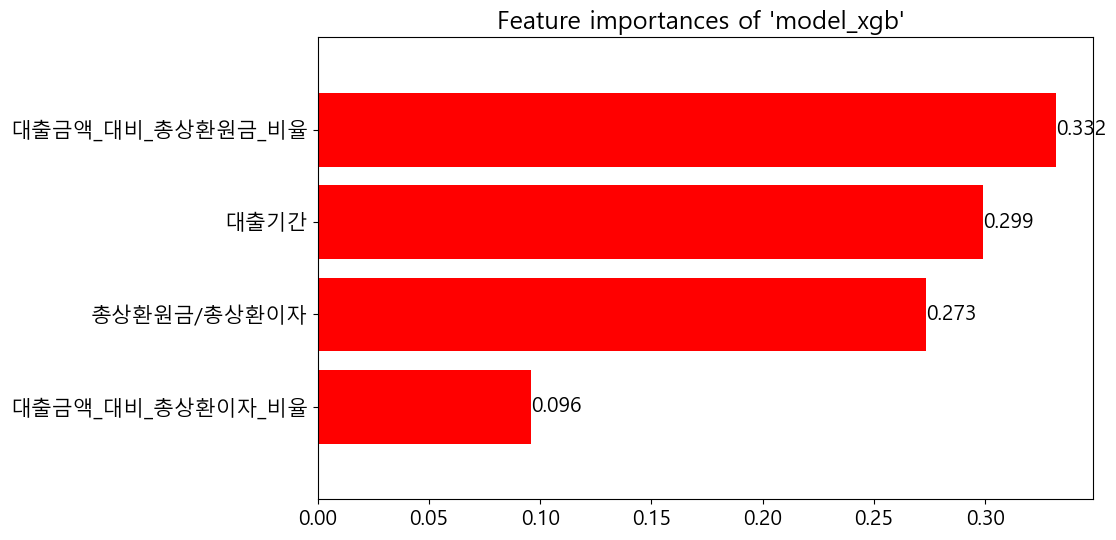

100%|██████████| 3/3 [00:00<00:00,  8.43it/s]


In [76]:
feature_importance(grid_search_best_models, remove_keys=['model_dt'], data_train=train_prep, x_var_list=selected_features)

### random search

In [55]:
random_search_model, random_search_results, random_search_best_models, random_search_cv_results = random_search(train_prep, selected_features)

  0%|          | 0/4 [00:00<?, ?it/s]c:\Users\kssg1\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 50 is smaller than n_iter=100. Running 50 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


model_dt하는 중
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END criterion=gini, max_depth=15; accuracy: (test=0.949) f1_macro: (test=0.944) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=15; accuracy: (test=0.946) f1_macro: (test=0.924) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=15; accuracy: (test=0.949) f1_macro: (test=0.936) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=15; accuracy: (test=0.947) f1_macro: (test=0.942) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=15; accuracy: (test=0.946) f1_macro: (test=0.926) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=16; accuracy: (test=0.950) f1_macro: (test=0.949) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=16; accuracy: (test=0.949) f1_macro: (test=0.936) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=16; accuracy: (test=0.950) f1_macro: (test=0.939) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=16; accuracy: (test=0.

 25%|██▌       | 1/4 [01:00<03:01, 60.65s/it]

model_rf하는 중
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END criterion=gini, max_depth=47, min_samples_split=2, n_estimators=50; accuracy: (test=0.953) f1_macro: (test=0.951) total time=   4.2s
[CV 2/5] END criterion=gini, max_depth=47, min_samples_split=2, n_estimators=50; accuracy: (test=0.953) f1_macro: (test=0.944) total time=   4.1s
[CV 3/5] END criterion=gini, max_depth=47, min_samples_split=2, n_estimators=50; accuracy: (test=0.954) f1_macro: (test=0.950) total time=   4.1s
[CV 4/5] END criterion=gini, max_depth=47, min_samples_split=2, n_estimators=50; accuracy: (test=0.953) f1_macro: (test=0.950) total time=   4.1s
[CV 5/5] END criterion=gini, max_depth=47, min_samples_split=2, n_estimators=50; accuracy: (test=0.951) f1_macro: (test=0.940) total time=   4.1s
[CV 1/5] END criterion=gini, max_depth=65, min_samples_split=3, n_estimators=310; accuracy: (test=0.953) f1_macro: (test=0.952) total time=  25.7s
[CV 2/5] END criterion=gini, max_depth=65, min_

 50%|█████     | 2/4 [1:41:16<1:58:47, 3563.80s/it]

model_et하는 중
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END criterion=gini, max_depth=47, min_samples_split=2, n_estimators=50; accuracy: (test=0.952) f1_macro: (test=0.951) total time=   1.2s
[CV 2/5] END criterion=gini, max_depth=47, min_samples_split=2, n_estimators=50; accuracy: (test=0.950) f1_macro: (test=0.941) total time=   1.2s
[CV 3/5] END criterion=gini, max_depth=47, min_samples_split=2, n_estimators=50; accuracy: (test=0.952) f1_macro: (test=0.941) total time=   1.2s
[CV 4/5] END criterion=gini, max_depth=47, min_samples_split=2, n_estimators=50; accuracy: (test=0.951) f1_macro: (test=0.947) total time=   1.2s
[CV 5/5] END criterion=gini, max_depth=47, min_samples_split=2, n_estimators=50; accuracy: (test=0.949) f1_macro: (test=0.935) total time=   1.2s
[CV 1/5] END criterion=gini, max_depth=65, min_samples_split=3, n_estimators=950; accuracy: (test=0.952) f1_macro: (test=0.950) total time=  25.0s
[CV 2/5] END criterion=gini, max_depth=65, min_

 75%|███████▌  | 3/4 [3:26:26<1:20:17, 4817.64s/it]

model_xgb하는 중
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END colsample_bytree=0.652542372881356, learning_rate=0.6, max_depth=62, min_child_weight=3, n_estimators=100, subsample=0.7, tree_method=auto; accuracy: (test=0.948) f1_macro: (test=0.931) total time=   2.1s
[CV 2/5] END colsample_bytree=0.652542372881356, learning_rate=0.6, max_depth=62, min_child_weight=3, n_estimators=100, subsample=0.7, tree_method=auto; accuracy: (test=0.948) f1_macro: (test=0.923) total time=   1.8s
[CV 3/5] END colsample_bytree=0.652542372881356, learning_rate=0.6, max_depth=62, min_child_weight=3, n_estimators=100, subsample=0.7, tree_method=auto; accuracy: (test=0.949) f1_macro: (test=0.931) total time=   1.9s
[CV 4/5] END colsample_bytree=0.652542372881356, learning_rate=0.6, max_depth=62, min_child_weight=3, n_estimators=100, subsample=0.7, tree_method=auto; accuracy: (test=0.947) f1_macro: (test=0.935) total time=   1.7s
[CV 5/5] END colsample_bytree=0.652542372881356, le

100%|██████████| 4/4 [5:31:30<00:00, 4972.74s/it]  

Model: model_dt
Best Parameters: {'max_depth': 18, 'criterion': 'entropy'}
Best F1-macro Score: 0.9430135747867038
Best Accuracy Score: 0.9507456596424569
Best Score: 0.9430135747867038

Model: model_rf
Best Parameters: {'n_estimators': 100, 'min_samples_split': 8, 'max_depth': 44, 'criterion': 'gini'}
Best F1-macro Score: 0.9477164467194635
Best Accuracy Score: 0.9528149047208994
Best Score: 0.9477164467194635

Model: model_et
Best Parameters: {'n_estimators': 600, 'min_samples_split': 5, 'max_depth': 49, 'criterion': 'entropy'}
Best F1-macro Score: 0.9446519490642105
Best Accuracy Score: 0.9518847912243487
Best Score: 0.9446519490642105

Model: model_xgb
Best Parameters: {'tree_method': 'exact', 'subsample': 0.7, 'n_estimators': 700, 'min_child_weight': 2, 'max_depth': 67, 'learning_rate': 0.39999999999999997, 'colsample_bytree': 0.635593220338983}
Best F1-macro Score: 0.9513273108669399
Best Accuracy Score: 0.9529403178656576
Best Score: 0.9513273108669399



In [56]:
random_search_results

{'model_dt': {'best_params': {'max_depth': 18, 'criterion': 'entropy'},
  'best_f1_score': 0.9430135747867038,
  'best_accuracy': 0.9507456596424569,
  'best_scores': 0.9430135747867038},
 'model_rf': {'best_params': {'n_estimators': 100,
   'min_samples_split': 8,
   'max_depth': 44,
   'criterion': 'gini'},
  'best_f1_score': 0.9477164467194635,
  'best_accuracy': 0.9528149047208994,
  'best_scores': 0.9477164467194635},
 'model_et': {'best_params': {'n_estimators': 600,
   'min_samples_split': 5,
   'max_depth': 49,
   'criterion': 'entropy'},
  'best_f1_score': 0.9446519490642105,
  'best_accuracy': 0.9518847912243487,
  'best_scores': 0.9446519490642105},
 'model_xgb': {'best_params': {'tree_method': 'exact',
   'subsample': 0.7,
   'n_estimators': 700,
   'min_child_weight': 2,
   'max_depth': 67,
   'learning_rate': 0.39999999999999997,
   'colsample_bytree': 0.635593220338983},
  'best_f1_score': 0.9513273108669399,
  'best_accuracy': 0.9529403178656576,
  'best_scores': 0.9513

In [64]:
random_search_cv_results

{'model_dt': {'mean_fit_time': array([0.2136919 , 0.20372834, 0.20580153, 0.20930061, 0.2089076 ,
         0.21481538, 0.20823212, 0.20673418, 0.20774956, 0.20519772,
         0.22341251, 0.21199794, 0.20798926, 0.21119199, 0.20758867,
         0.2208004 , 0.20738821, 0.2123929 , 0.21719742, 0.21499534,
         0.21179271, 0.20959034, 0.21339393, 0.21399417, 0.21019101,
         0.25443096, 0.24902596, 0.24471946, 0.25082779, 0.24301996,
         0.24802537, 0.24322076, 0.24562316, 0.24782491, 0.2462235 ,
         0.25302992, 0.26063695, 0.24582496, 0.25188923, 0.27745304,
         0.26182861, 0.26926031, 0.2560946 , 0.2463203 , 0.24962878,
         0.25178905, 0.25354195, 0.25258565, 0.24075651, 0.24724746]),
  'std_fit_time': array([0.01497404, 0.00443962, 0.00548335, 0.00471096, 0.00639674,
         0.01797855, 0.00499425, 0.00384672, 0.00363227, 0.00343854,
         0.01710248, 0.00685246, 0.0045381 , 0.00548181, 0.00257915,
         0.02375008, 0.00222931, 0.00796712, 0.01977643,

In [57]:
random_search_best_models

{'model_dt': DecisionTreeClassifier(criterion='entropy', max_depth=18, random_state=42),
 'model_rf': RandomForestClassifier(max_depth=44, min_samples_split=8, random_state=42),
 'model_et': ExtraTreesClassifier(criterion='entropy', max_depth=49, min_samples_split=5,
                      n_estimators=600, random_state=42),
 'model_xgb': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.635593220338983, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.39999999999999997,
               max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=67, max_leaves=None,
               min_child_weight=2, missing=nan, monotone_con

In [61]:
random_search_best_models['model_dt'].get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 18,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

### 특성 중요도 2

  0%|          | 0/3 [00:00<?, ?it/s]

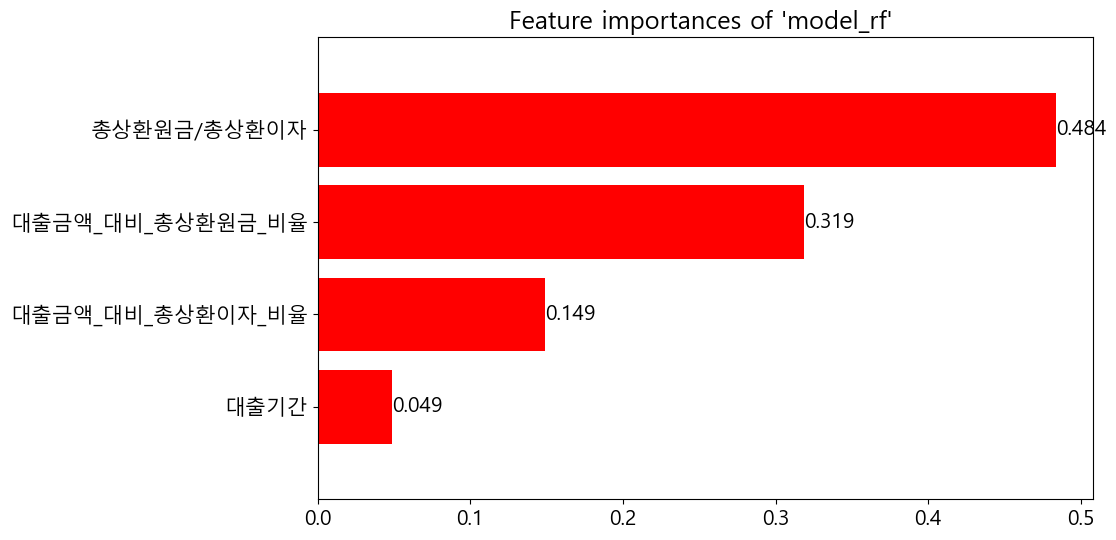

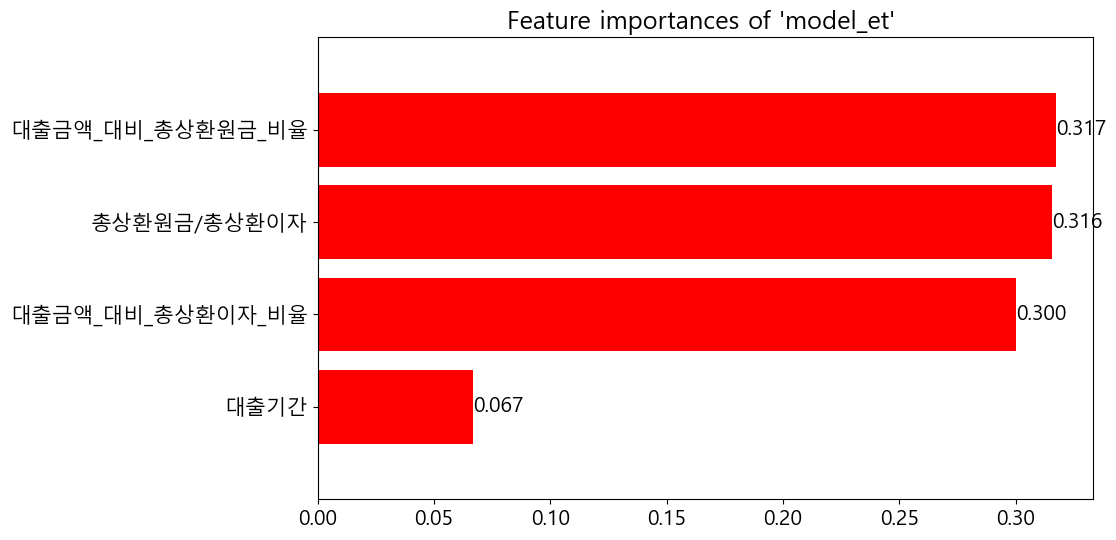

 67%|██████▋   | 2/3 [00:00<00:00,  8.18it/s]

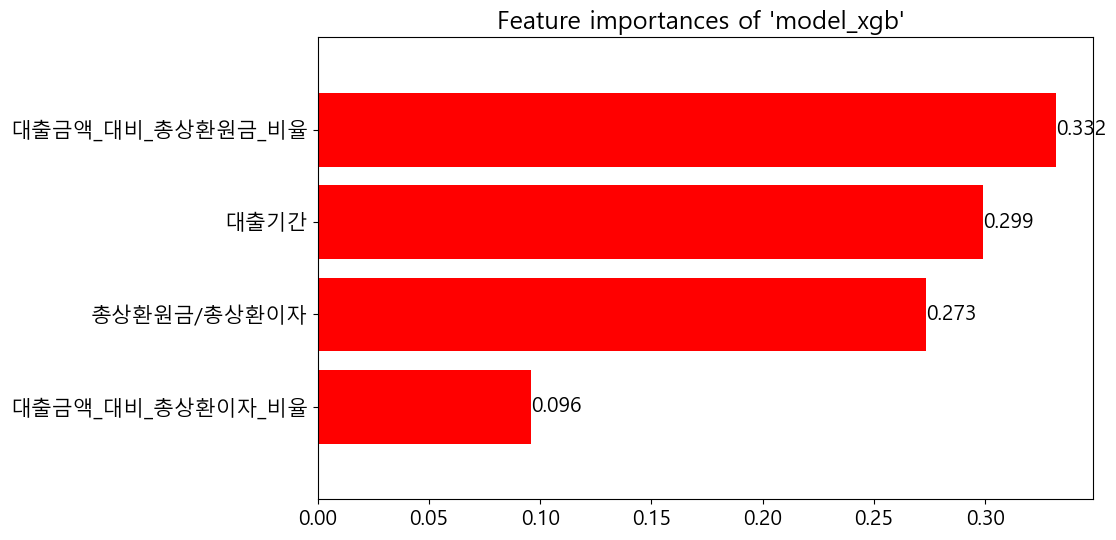

100%|██████████| 3/3 [00:00<00:00,  8.50it/s]


In [63]:
feature_importance(random_search_best_models, remove_keys=['model_dt'], data_train=train_prep, x_var_list=selected_features)

### RFE

In [52]:
models = {
        'model_dt': DecisionTreeClassifier(max_depth=25, random_state=42), 
        'model_rf': RandomForestClassifier(max_depth=62, n_estimators=100, random_state=42), 
        'model_et': ExtraTreesClassifier(max_depth=65, n_estimators=100, random_state=42), 
        'model_xgb': XGBClassifier(max_depth=64, n_estimators=50, random_state=42), 
    }
rfe_model, rfe_feature_infos = rfe(train_prep, selected_features, models=models)

  0%|          | 0/4 [00:00<?, ?it/s]

Model: model_dt
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.


 25%|██▌       | 1/4 [00:08<00:25,  8.65s/it]

Optimal number of features for model_dt : 3
Features sorted by their rank:
[(1, '대출금액_대비_총상환원금_비율'), (1, '대출기간'), (1, '총상환원금/총상환이자'), (2, '대출금액_대비_총상환이자_비율'), (3, '부채_대비_소득_비율'), (4, '연간소득'), (5, '총연체금액')]
Model: model_rf
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting 

 50%|█████     | 2/4 [05:33<06:29, 194.67s/it]

Optimal number of features for model_rf : 3
Features sorted by their rank:
[(1, '대출금액_대비_총상환원금_비율'), (1, '대출금액_대비_총상환이자_비율'), (1, '총상환원금/총상환이자'), (2, '부채_대비_소득_비율'), (3, '대출기간'), (4, '연간소득'), (5, '총연체금액')]
Model: model_et
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting 

 75%|███████▌  | 3/4 [07:44<02:45, 165.41s/it]

Optimal number of features for model_et : 2
Features sorted by their rank:
[(1, '대출금액_대비_총상환원금_비율'), (1, '대출금액_대비_총상환이자_비율'), (2, '총상환원금/총상환이자'), (3, '부채_대비_소득_비율'), (4, '연간소득'), (5, '대출기간'), (6, '총연체금액')]
Model: model_xgb
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting

100%|██████████| 4/4 [08:36<00:00, 129.05s/it]

Optimal number of features for model_xgb : 5
Features sorted by their rank:
[(1, '대출금액_대비_총상환원금_비율'), (1, '대출금액_대비_총상환이자_비율'), (1, '대출기간'), (1, '총상환원금/총상환이자'), (1, '총연체금액'), (2, '연간소득'), (3, '부채_대비_소득_비율')]


대출기간: 0.5899773240089417
총상환원금/총상환이자: 0.3008853495121002
대출금액_대비_총상환원금_비율: 0.082110196352005
대출금액_대비_총상환이자_비율: 0.019953755661845207
총연체금액: 0.0070734270848333836


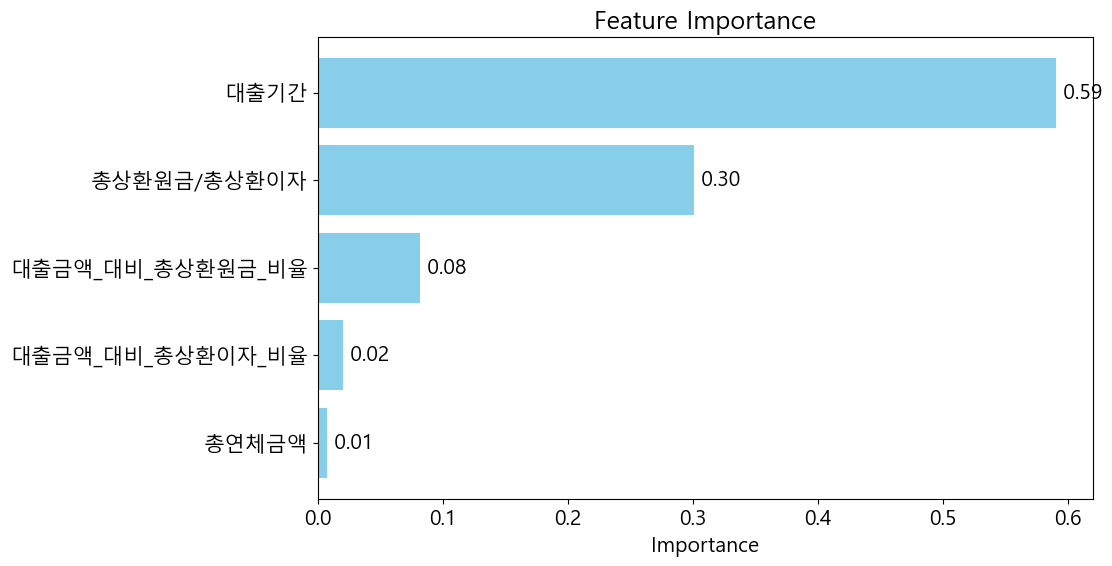

In [53]:
# 선택된 특성의 이름 가져오기
selected_features_for_graph = train_prep[selected_features].columns[rfe_model.support_]

# 특성 중요도와 매칭
importance_dict = {}
for i, feature_name in enumerate(selected_features_for_graph):
    importance_dict[feature_name] = rfe_model.estimator_.feature_importances_[i]

# 특성 중요도를 내림차순으로 정렬
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# 특성 이름과 중요도 추출
features = [x[0] for x in sorted_importance]
importances = [x[1] for x in sorted_importance]

# 특성 중요도 출력
for feature, importance in zip(features, importances):
    print(f"{feature}: {importance}")

# 막대 그래프 그리기
plt.figure(figsize=(10, 6))
bars = plt.barh(features, importances, color='skyblue')

# 막대 끝에 값 표시
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f' {width:.2f}', ha='left', va='center')

plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [81]:
features

['대출기간', '총상환원금', '총상환이자', '대출금액']

In [51]:
rfe_model.estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=64, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

### stack

In [53]:
stack_model=stacking_clf(train_prep, selected_features)

c:\Users\kssg1\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 학습 모델 저장 & 불러오기

## 학습 모델 저장

In [83]:
# 그리드 탐색용
current_time = datetime.now().strftime("%Y-%m-%d_%H%M%S")
pickle_filename = 'grid_derive_all(select4)_vs_search'+ current_time +'.pkl'
joblib.dump(grid_search_best_models, pickle_filename, compress=6)

['grid_derive_all(select4)_vs_search2024-02-18_001532.pkl']

In [65]:
# 랜덤 탐색용
current_time = datetime.now().strftime("%Y-%m-%d_%H%M%S")
pickle_filename = 'random_derive_all(select4)_more_search'+ current_time +'.pkl'
joblib.dump(random_search_best_models, pickle_filename, compress=6)

['random_derive_all(select4)_more_search2024-02-17_210854.pkl']

## 학습 모델 불러오기

In [55]:
loaded_dict = joblib.load('grid_derive_all(select4)2024-02-16_200910.pkl')

In [82]:
loaded_dict['model_dt'].tree_.max_depth

25

# test 예측값 만들기
학습시킬 때와 동일한 컬럼만 넣어주기

In [52]:
answer = rfe_model.estimator_.predict(real_test[selected_features])
submission['대출등급']=pd.Series(answer).map({v: k for k, v in target_dict.items()})

## 파일로 저장

In [53]:
current_time = datetime.now().strftime("%Y-%m-%d_%H%M%S")
filename = 'submission_' + current_time + '.csv'
submission.to_csv(filename, index = False)

## 여러 모델 한번에 처리하기

In [109]:
# 그리드 탐색용
for key, value in grid_search_best_models.items():
    answer = grid_search_best_models[key].predict(real_test[selected_features])
    submission['대출등급']=pd.Series(answer).map({v: k for k, v in target_dict.items()})
    current_time = datetime.now().strftime("%Y-%m-%d_%H%M%S")
    filename = 'submission_' + key + current_time + '.csv'
    submission.to_csv(filename, index = False)

In [66]:
# 랜덤 탐색용
for key, value in random_search_best_models.items():
    answer = random_search_best_models[key].predict(real_test[selected_features])
    submission['대출등급']=pd.Series(answer).map({v: k for k, v in target_dict.items()})
    current_time = datetime.now().strftime("%Y-%m-%d_%H%M%S")
    filename = 'submission_radom_' + key + current_time + '.csv'
    submission.to_csv(filename, index = False)

##### 필요X부분

In [2]:
import gc

# 가비지 컬렉션 강제 실행
gc.collect()

16

In [89]:
# xgb 에러 해결할려고 확인한 부분들
# y_train.info()
# y_train.isna().sum()
# print(y_train['대출등급_en'].unique())
# print(y_dict)
# print(y_dict.values())
# print("X_train의 행 수:", len(X_train))
# print("y_train의 행 수:", len(y_train['대출등급_en']))
# print(X_train.columns)
# print(col_dummies)
# pd.set_option('display.max_columns', None)
# X_train.head(3)

In [90]:
# %%time
# for model in ['lor', 'dt', 'rf', 'knn', 'gbm', 'xgb', 'lgb']:
#     get_score(X_train, X_test, col_dummies + numeric_col, model_type=model, cm_on =False)
# # get_score(X_train, X_test, col_dummies + numeric_col, model_type='rf')
# # get_score(X_train, X_test, col_dummies + numeric_col, model_type='xgb')

라는 이상한 형태였다는 것? -> 연간 소득이 0이라서 그리 큰값이 나온듯했음    
연간소득 0 인 사람 저 사람 혼자뿐 그리고 그외 최소 연간소득이 1440000이였음

# 추가로 고려해야할 부분

이상치로 판단되어 제외해줬던 부채_대비_소득 비율 9999.0이였던 사람이 

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>대출금액</th>
      <th>대출기간</th>
      <th>근로기간</th>
      <th>주택소유상태</th>
      <th>연간소득</th>
      <th>부채_대비_소득_비율</th>
      <th>총계좌수</th>
      <th>대출목적</th>
      <th>최근_2년간_연체_횟수</th>
      <th>총상환원금</th>
      <th>총상환이자</th>
      <th>총연체금액</th>
      <th>연체계좌수</th>
      <th>대출등급</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>12498</th>
      <td>4440000</td>
      <td>36 months</td>
      <td>Unknown</td>
      <td>MORTGAGE</td>
      <td>0</td>
      <td>9999.0</td>
      <td>20</td>
      <td>신용 카드</td>
      <td>2</td>
      <td>205356</td>
      <td>85884.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>C</td>
    </tr>
  </tbody>
</table>
</div>